# SETTINGS

Check the Python version

In [2]:
import sys
print("Python version:", sys.version)

Python version: 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]


Import packages

In [3]:
import numpy as np
import sys
import pandas as pd
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import zivot_andrews
from statsmodels.regression.linear_model import OLS

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp
from tigramite.plotting import plot_time_series_graph

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

import cdsapi
import random
import zipfile

import netCDF4 as nc
import xarray as xr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.subplots as sp

import seaborn as sns

from arch.unitroot import PhillipsPerron
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import f

import networkx as nx

from scipy.stats import pearsonr

import dagviz
from collections import Counter

from tqdm import tqdm

import nbformat

import pingouin as pg

import chow_test 
from chow_test import chow_test

/Users/juliette/anaconda3/envs/envEmma/lib/python3.9/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Data

Emma starts out by defining the length and staring year, before she imports the data.

In [4]:
start_year = 1950
length = 12*(2022 - start_year)

## WPAC = Sea level pressure (in Pa) in the West Pacific

This is the only key variable of the Bjerknes effect that seemed different when I downloaded it again. I am using the reference to Emma's version here.

In [5]:
WPAC = np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [6]:
mean = np.mean(WPAC)
std_dev = np.std(WPAC)
median = np.median(WPAC)
min_val = np.min(WPAC)
max_val = np.max(WPAC)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Median:", median)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Mean: 100934.85266203702
Standard Deviation: 93.61832329131148
Median: 100938.0
Minimum Value: 100659.9
Maximum Value: 101247.5


In [7]:
start_year = 1950
end_year = 2022
plot_length = 12 * (end_year - start_year + 1)
time_index = pd.date_range(start=f'{start_year}-01', periods=plot_length, freq='MS')
time_index = time_index[:len(WPAC)]

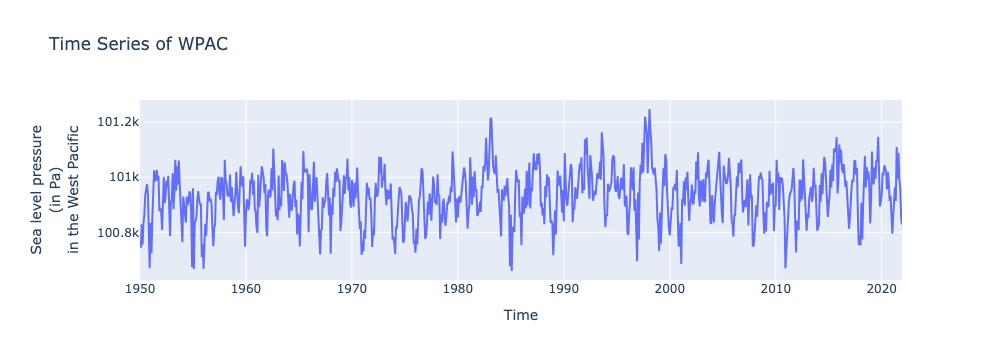

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=WPAC, mode='lines', name='WPAC'))
fig.update_layout(
    title='Time Series of WPAC',
    xaxis_title='Time',
    yaxis_title='Sea level pressure<br>(in Pa)<br>in the West Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

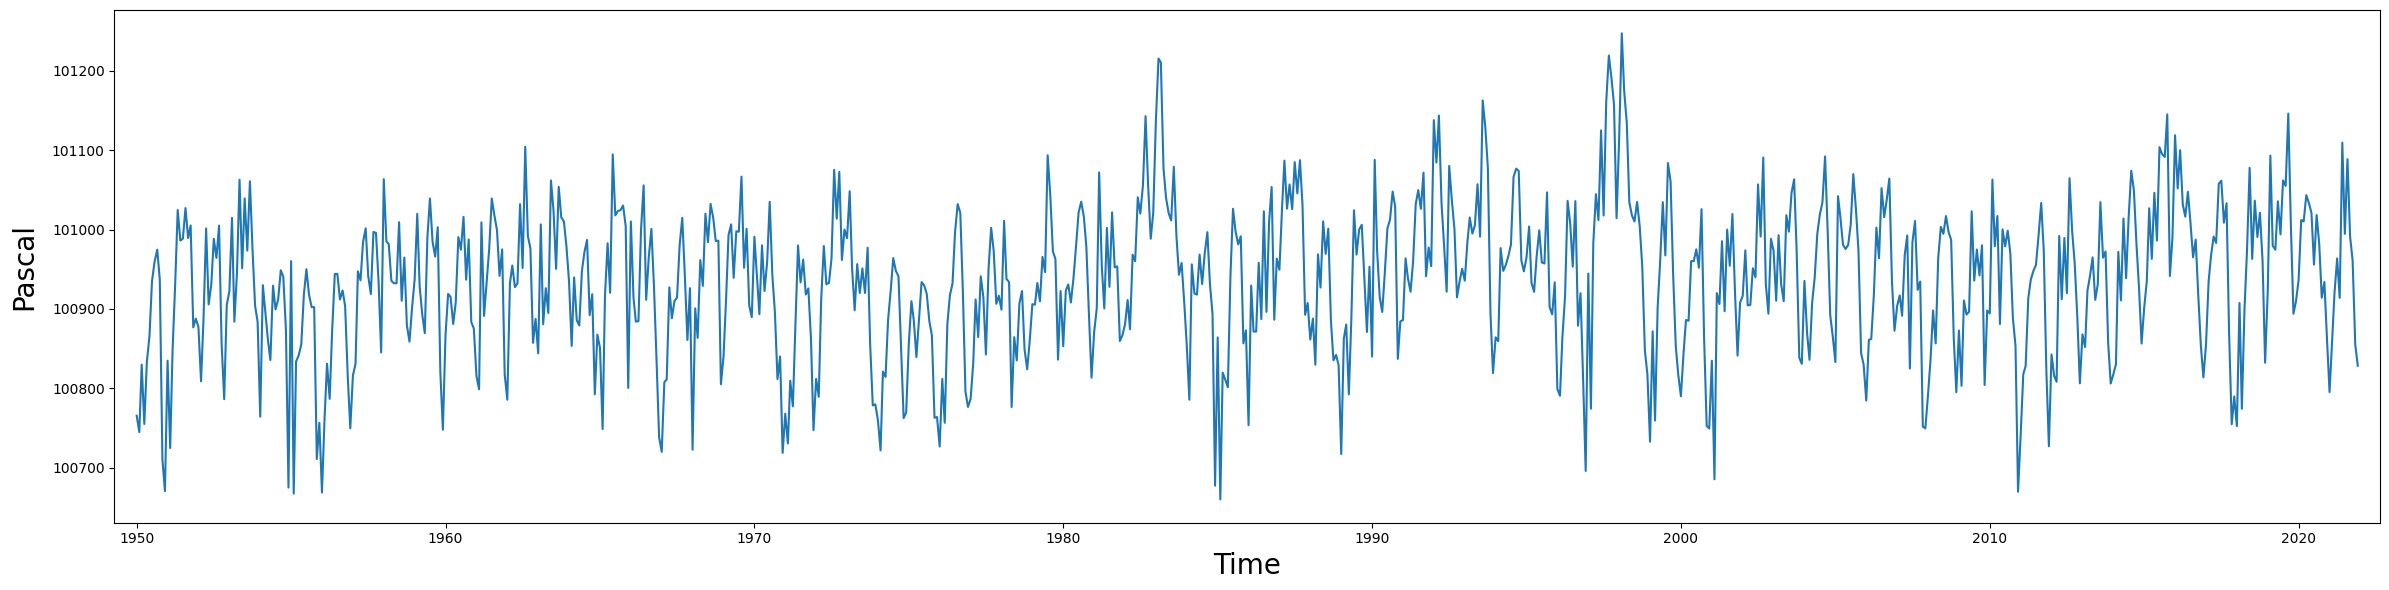

In [9]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=time_index, y=WPAC) #, label='WPAC'

#plt.title('Sea Level Pressure (in Pa) in the West Pacific', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Pascal', fontsize=20)

plt.gca().margins(x=0.01)  
plt.gca().yaxis.labelpad = 10  

plt.tight_layout()
plt.show()

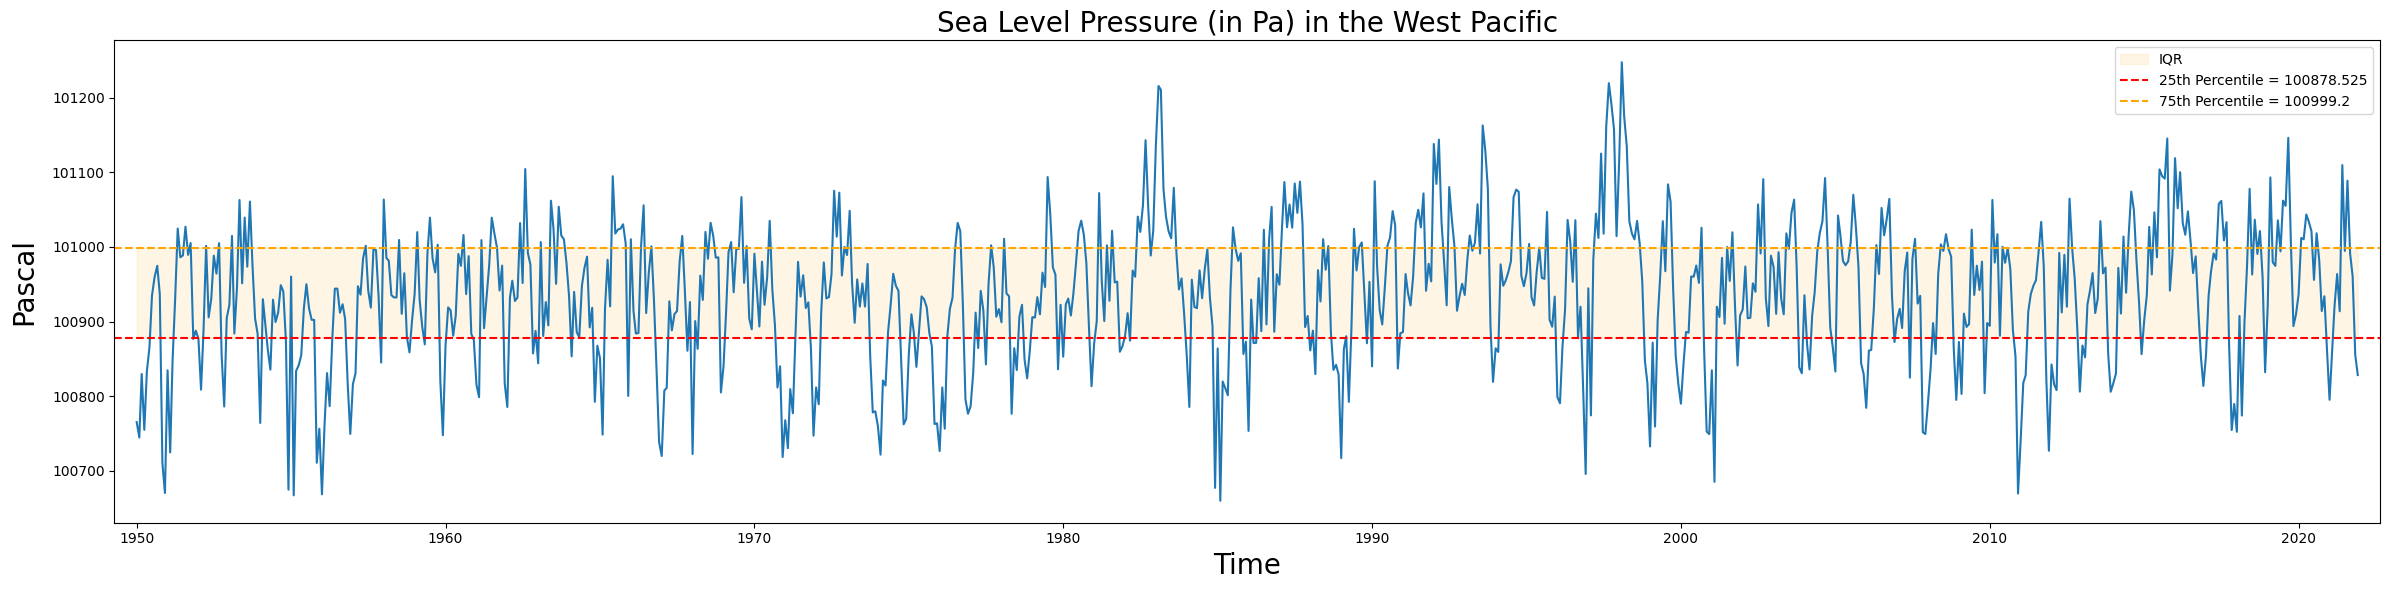

In [10]:
Q1_WPAC = np.percentile(WPAC, 25)
Q3_WPAC = np.percentile(WPAC, 75)
IQR_WPAC = Q3_WPAC - Q1_WPAC

plt.figure(figsize=(24, 6))
sns.lineplot(x=time_index, y=WPAC) #, label='WPAC'

# Add the quartiles and IQR
plt.fill_between(time_index, Q1_WPAC, Q3_WPAC, color='orange', alpha=0.1, label='IQR')
plt.axhline(Q1_WPAC, color='red', linestyle='--', label=f'25th Percentile = {Q1_WPAC}')
plt.axhline(Q3_WPAC, color='orange', linestyle='--', label=f'75th Percentile = {Q3_WPAC}')

plt.title('Sea Level Pressure (in Pa) in the West Pacific', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Pascal', fontsize=20)

plt.gca().margins(x=0.01)  
plt.gca().yaxis.labelpad = 10  

plt.legend()
plt.tight_layout()
plt.show()

## CPAC = Near surface temperature (in K) in the Central Pacific

In [11]:
CPAC = np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [12]:
mean = np.mean(CPAC)
std_dev = np.std(CPAC)
median = np.median(CPAC)
min_val = np.min(CPAC)
max_val = np.max(CPAC)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Median:", median)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Mean: 298.8509971064815
Standard Deviation: 0.8447594851404049
Median: 298.91795
Minimum Value: 296.1973
Maximum Value: 300.8865


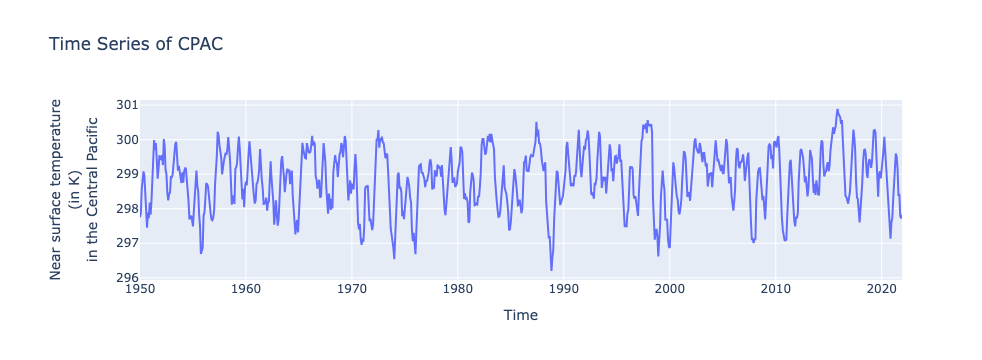

In [13]:
time_index = time_index[:len(CPAC)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=CPAC, mode='lines', name='CPAC'))
fig.update_layout(
    title='Time Series of CPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

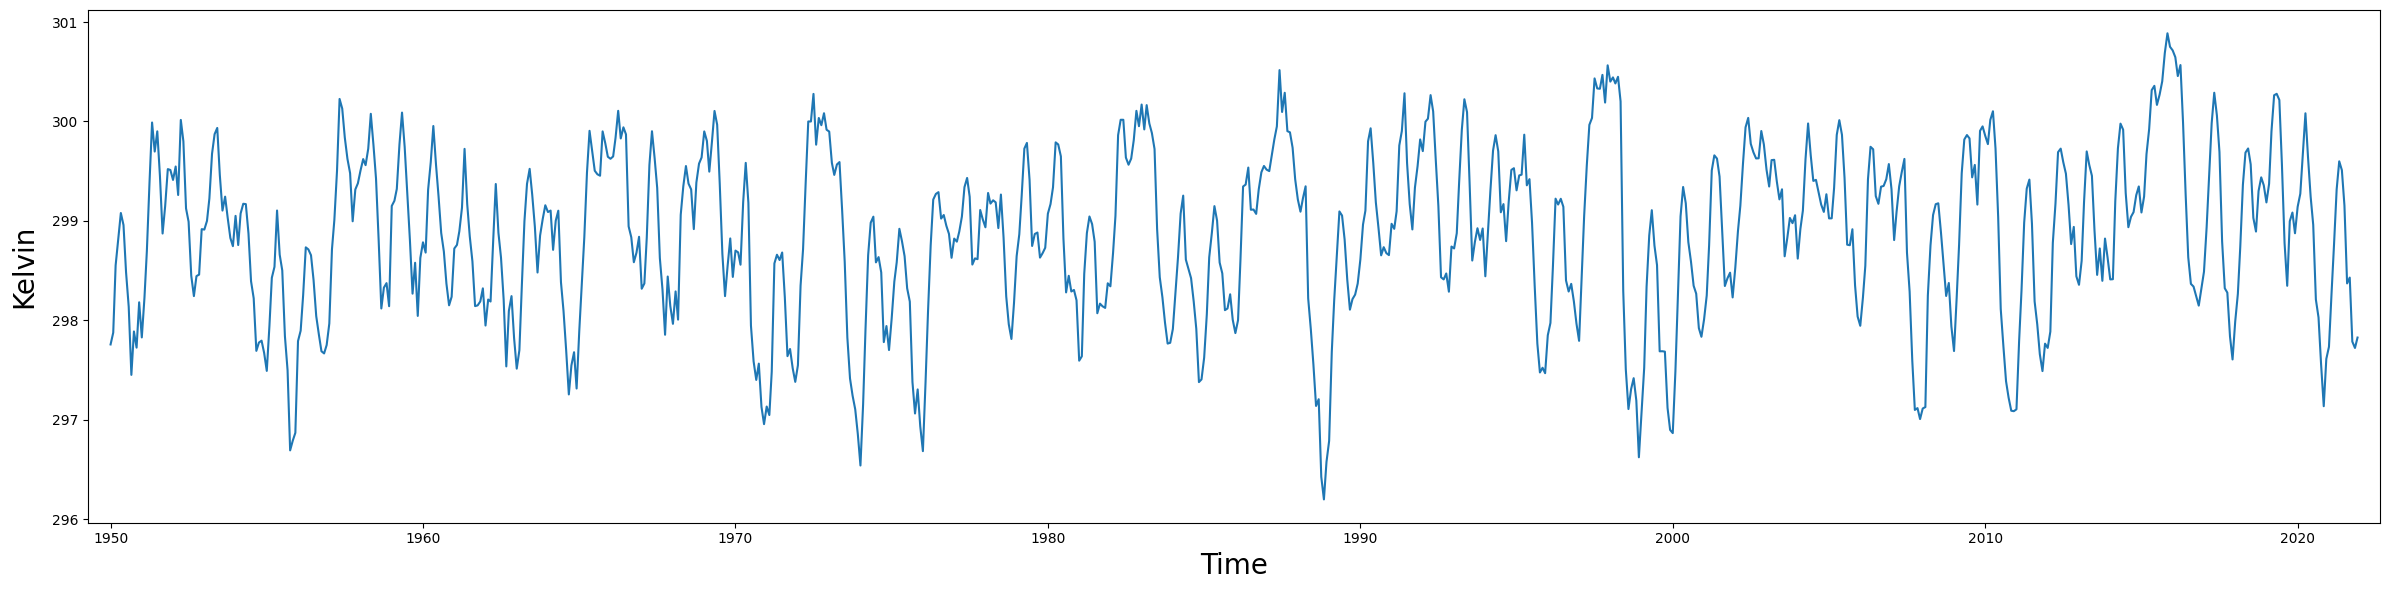

In [14]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=time_index, y=CPAC) #, label='CPAC'

#plt.title('Near Surface Temperature (in K) in the Central Pacific', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Kelvin', fontsize=20)

plt.gca().margins(x=0.01)  
plt.gca().yaxis.labelpad = 10  

plt.tight_layout()
plt.show()

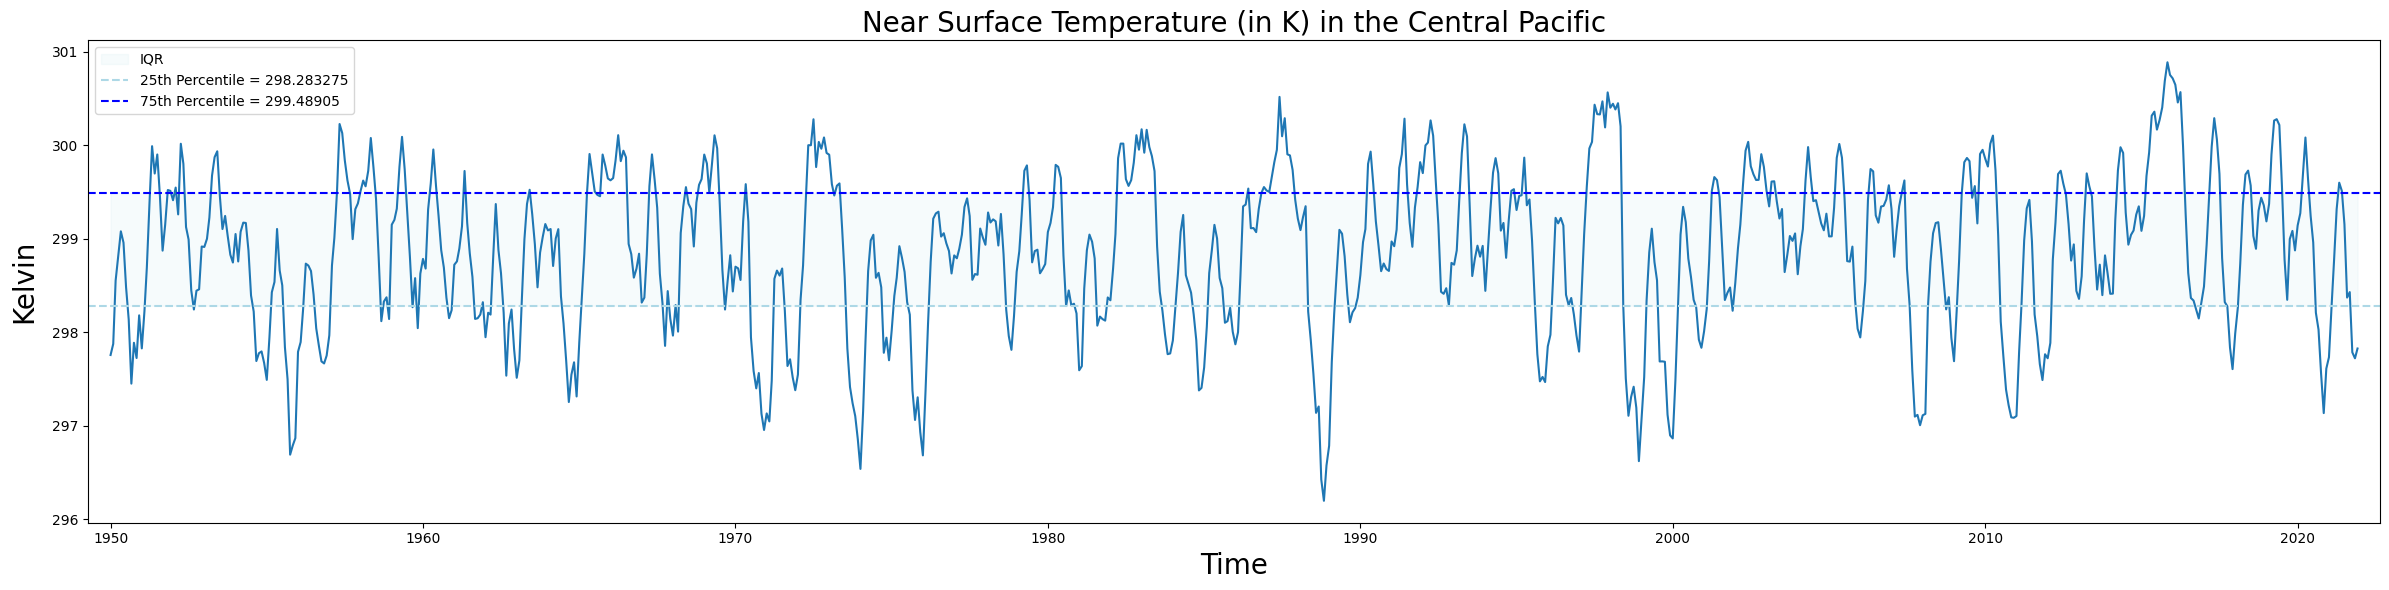

In [15]:
Q1_CPAC = np.percentile(CPAC, 25)
Q3_CPAC = np.percentile(CPAC, 75)
IQR_CPAC = Q3_CPAC - Q1_CPAC

plt.figure(figsize=(24, 6))
sns.lineplot(x=time_index, y=CPAC) #, label='WPAC'

# Add the quartiles and IQR
plt.fill_between(time_index, Q1_CPAC, Q3_CPAC, color='lightblue', alpha=0.1, label='IQR')
plt.axhline(Q1_CPAC, color='lightblue', linestyle='--', label=f'25th Percentile = {Q1_CPAC}')
plt.axhline(Q3_CPAC, color='blue', linestyle='--', label=f'75th Percentile = {Q3_CPAC}')

plt.title('Near Surface Temperature (in K) in the Central Pacific', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Kelvin', fontsize=20)

plt.gca().margins(x=0.01)  
plt.gca().yaxis.labelpad = 10  

plt.legend()
plt.tight_layout()
plt.show()

## EPAC = Near surface temperature (in K) in the East Pacific

In [16]:
EPAC = np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [17]:
mean = np.mean(EPAC)
std_dev = np.std(EPAC)
median = np.median(EPAC)
min_val = np.min(EPAC)
max_val = np.max(EPAC)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Median:", median)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Mean: 296.9792201388889
Standard Deviation: 1.5031017287062765
Median: 296.94034999999997
Minimum Value: 293.807
Maximum Value: 300.8609


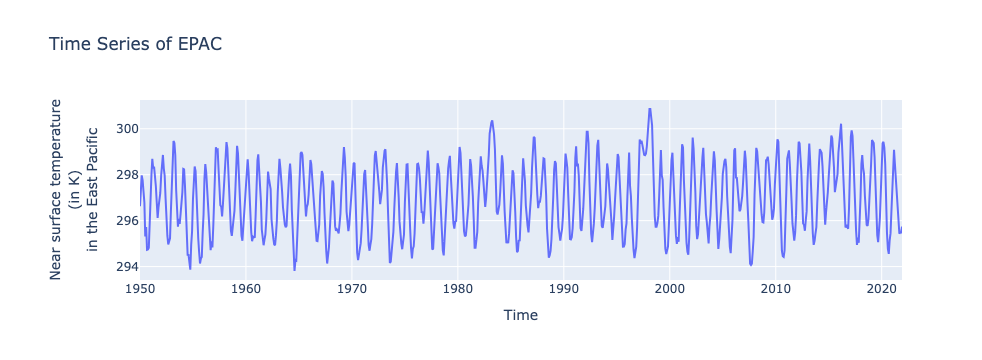

In [18]:
time_index = time_index[:len(EPAC)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=EPAC, mode='lines', name='EPAC'))
fig.update_layout(
    title='Time Series of EPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the East Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

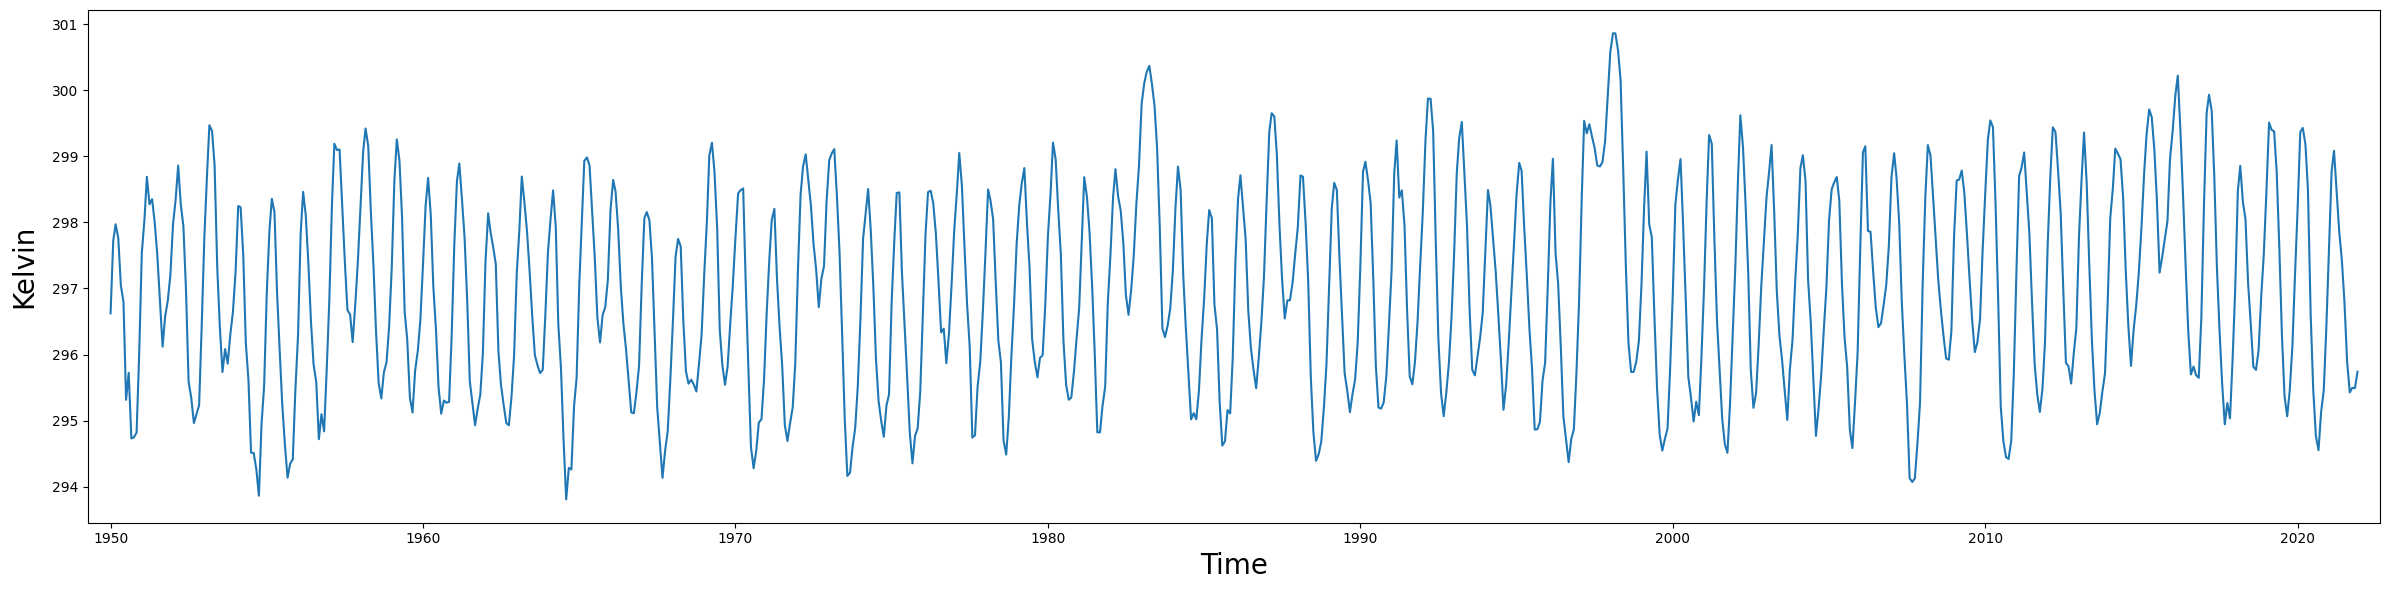

In [19]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=time_index, y=EPAC) #, label='CPAC'

#plt.title('Near Surface Temperature (in K) in the East Pacific', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Kelvin', fontsize=20)

plt.gca().margins(x=0.01)  
plt.gca().yaxis.labelpad = 10  

plt.tight_layout()
plt.show()

## TW = Near surface winds (in m/s) in the Central Pacific

Note that we make a transformation for the trade winds, multiplying it by -1 to change the direction of the winds. They are typically from west to east, but for our interpretation it is better to use them from east to west.

In [20]:
TW = np.loadtxt('iera5_u10m_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]
TW *= -1 

In [21]:
mean = np.mean(TW)
std_dev = np.std(TW)
median = np.median(TW)
min_val = np.min(TW)
max_val = np.max(TW)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Median:", median)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Mean: 5.440672281446759
Standard Deviation: 1.0029878863066852
Median: 5.5784445
Minimum Value: -0.3439944
Maximum Value: 7.407164


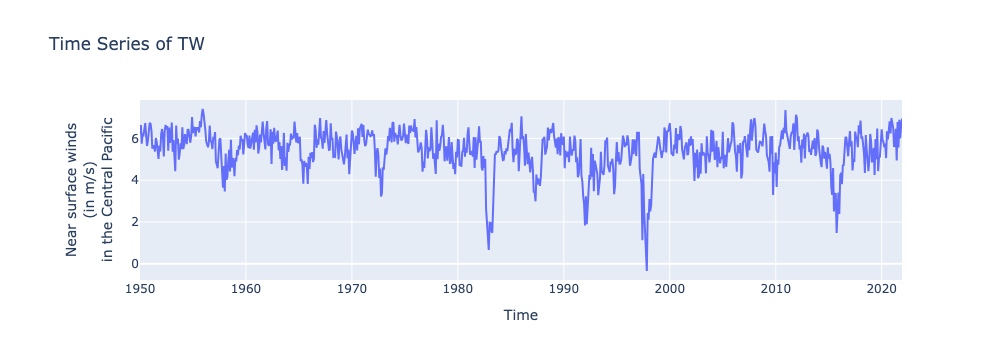

In [22]:
time_index = time_index[:len(TW)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=TW, mode='lines', name='TW'))

fig.update_layout(
    title='Time Series of TW',
    xaxis_title='Time',
    yaxis_title='Near surface winds<br>(in m/s)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)

fig.show()

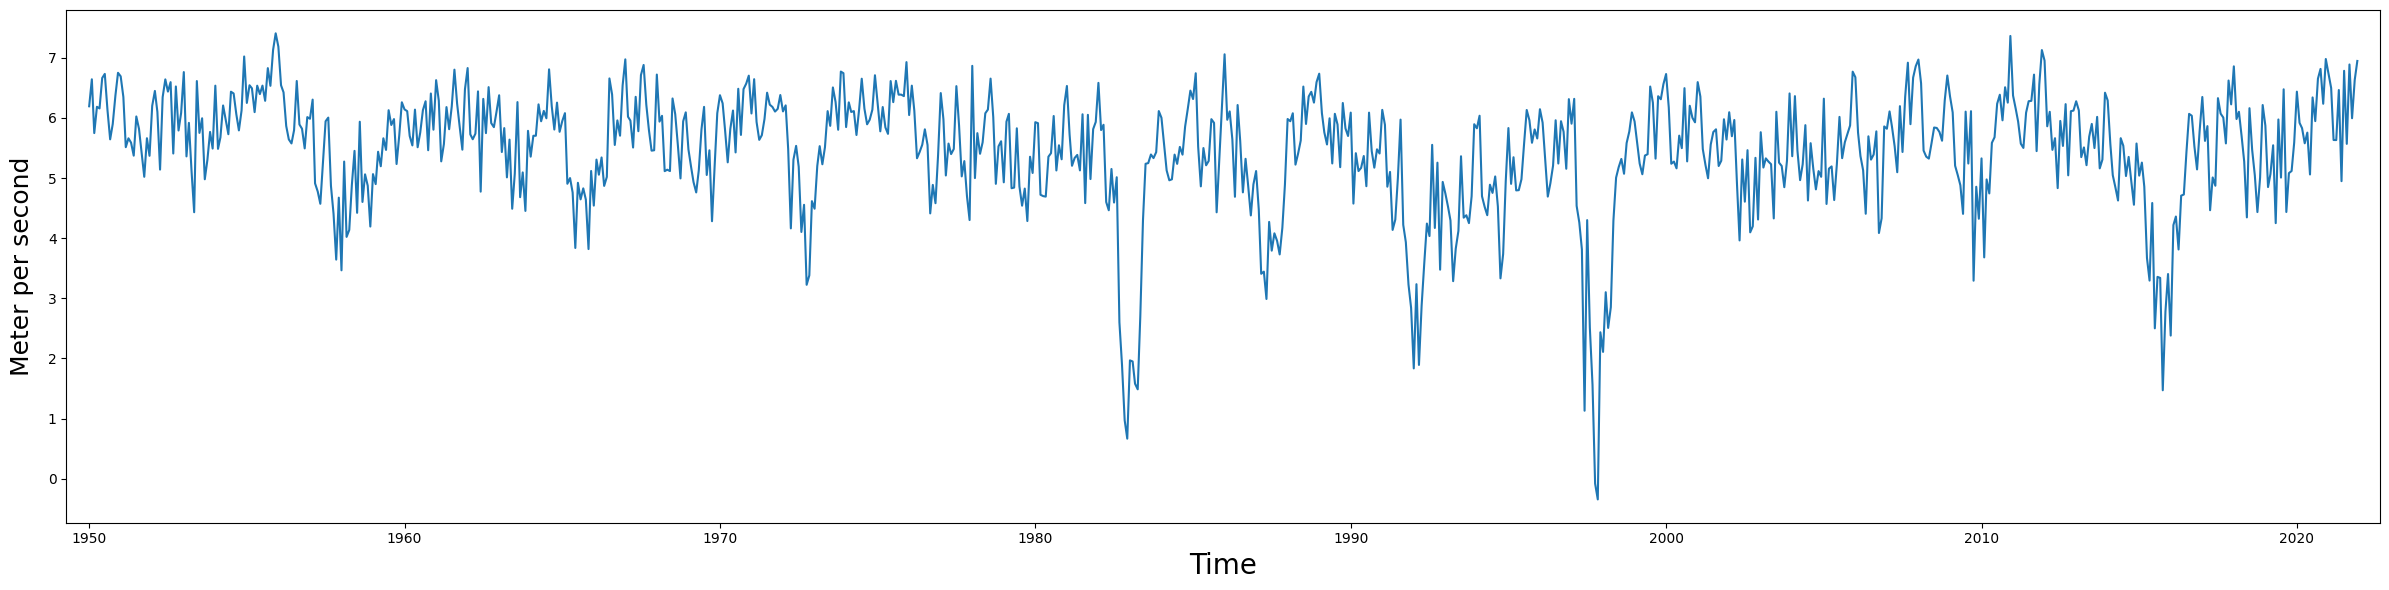

In [23]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=time_index, y=TW) #, label='CPAC'

#plt.title('Near surface winds (in m/s) in the Central Pacific', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Meter per second', fontsize=18)

plt.gca().margins(x=0.01)  
plt.gca().yaxis.labelpad = 10  

plt.tight_layout()
plt.show()


## NHF = Net turbulent heat fluxes (in W/m2) in the Central Pacific

Note that we make a transformation for the net turbulent heat fluxes, multiplying it by -1/2 to ...?

In [24]:
NHF = np.loadtxt('iera5_trbflx_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]
NHF *= -1/2

In [25]:
mean = np.mean(NHF)
std_dev = np.std(NHF)
median = np.median(NHF)
min_val = np.min(NHF)
max_val = np.max(NHF)

print("Mean:", mean)
print("Standard Deviation:", std_dev)
print("Median:", median)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Mean: 63.124956203703704
Standard Deviation: 8.478761447952177
Median: 63.4931
Minimum Value: 41.100155
Maximum Value: 94.32535


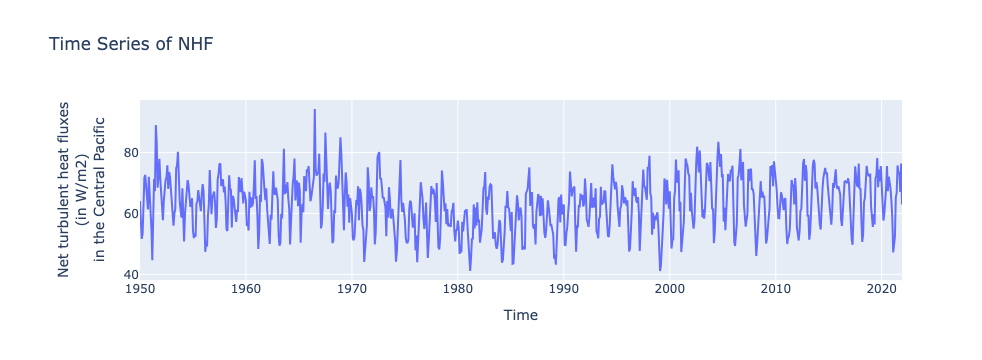

In [26]:
time_index = time_index[:len(NHF)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=NHF, mode='lines', name='NHF'))

fig.update_layout(
    title='Time Series of NHF',
    xaxis_title='Time',
    yaxis_title='Net turbulent heat fluxes<br>(in W/m2)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)

fig.show()

## Extended Dataset

We will store all the data of the five key variables in an extended numpy array so we can easily access it, following Emma's approach.

In [27]:
extended_data = np.vstack((
    WPAC,
    CPAC,
    EPAC,
    TW,
    NHF
                ))

To make sure we can easily work with it, we also transform the data set.

In [28]:
extended_data = extended_data.T

In [29]:
print(extended_data.shape)
henze_zirkler_result = pg.multivariate_normality(extended_data, alpha=0.05)
print(henze_zirkler_result)

(864, 5)
HZResults(hz=3.831295539607487, pval=2.768322445917278e-150, normal=False)


## MIROC6 Data

Later on in the analysis we will compare the reanalysis data to model data. One of the models Emma uses is MIROC6. We will load the data here following her approach. First off, define a function to make series from nc-files.

In [30]:
def ncfiles_to_series(nc_file_name, csv_file_name, var_name, model_map):
# Open the NetCDF file
    file_path = nc_file_name
    ds = xr.open_dataset(file_path)
    ds.to_dataframe().to_csv(csv_file_name)
    var = pd.read_csv(csv_file_name)
    # Convert the 'time' column to datetime type
    var['time'] = pd.to_datetime(var['time'])
    # Group the DataFrame by the date and calculate the mean of 'ts' for each date
    var = var.groupby(var['time'].dt.date)[var_name].mean()
    array = []
    for i in range(len(var)):
        array.append(var[i])
    return array

Now we can load the data using Emma's approach, and make the correct transformations.

In [31]:
MIROC6_nc_names = ['psl_Amon_MIROC6_historical_r1i1p1f1_gn_19500116-20141216_v20181212.nc',
             'Ctas_Amon_MIROC6_historical_r1i1p1f1_gn_19500116-20141216_v20181212.nc',
             'tas_Amon_MIROC6_historical_r1i1p1f1_gn_19500116-20141216_v20181212.nc',
             'uas_Amon_MIROC6_historical_r1i1p1f1_gn_19500116-20141216_v20181212.nc',
             'hfls_Amon_MIROC6_historical_r1i1p1f1_gn_19500116-20141216_v20181212.nc',
             'hfss_Amon_MIROC6_historical_r1i1p1f1_gn_19500116-20141216_v20181212.nc']

MIROC6_csv_names = ['mean_WPAC_MIROC6',
                   'mean_CPAC_MIROC6',
                   'mean_EPAC_MIROC6',
                   'mean_ZWS_MIROC6',
                   'mean_LHF_MIROC6',
                   'mean_SHF_MIROC6'
                  ]

MIROC6_var_names = ['psl',
            'tas',
            'tas',
            'uas',
            'hfls',
            'hfss']

MIROC6_data = []

for i in range(len(MIROC6_nc_names)):
    if i ==0:
        data = ncfiles_to_series(MIROC6_nc_names[i],MIROC6_csv_names[i], MIROC6_var_names[i], 'MIROC')
    else:
        more_data = ncfiles_to_series(MIROC6_nc_names[i], MIROC6_csv_names[i], MIROC6_var_names[i], 'MIROC')
        data = np.vstack((data, more_data)) 
        
MIROC6_data = data

last_two_mean = np.mean(MIROC6_data[-2:, :], axis=0)
MIROC6_data = data[:-2, :]
MIROC6_data[3, :] *= -1

MIROC6_data_final = np.vstack((MIROC6_data, last_two_mean))
MIROC6_data_final = MIROC6_data_final.T

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/ipykernel_12273/4124393449.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/ipykernel_12273/4124393449.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/ipykernel_12273/4124393449.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/

## EC-Earth3 Data

Like the MIROC6 data, we will also use the EC-Earth3 data to compare our reanalysis results to. Therefore, import it in the same manner (following Emma's approach).

In [32]:
ECearth_nc_names = ['psl_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19500116-20141216_v20200624.nc',
             'tas_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19500116-20141216_v20200624.nc',
             'Etas_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19500116-20141216_v20200624.nc',
             'uas_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19500116-20141216_v20200624.nc',
             'hfls_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19500116-20141216_v20200624.nc',
             'hfss_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19500116-20141216_v20200624.nc']

ECearth_csv_names = ['mean_WPAC_ECearth',
                   'mean_CPAC_ECearth',
                   'mean_EPAC_ECearth',
                   'mean_ZWS_ECearth',
                   'mean_LHF_ECearth',
                   'mean_SHF_ECearth'
                  ]

ECearth_var_names = ['psl',
            'tas',
            'tas',
            'uas',
            'hfls',
            'hfss']

ECearth_data = []

for i in range(len(ECearth_nc_names)):
    if i ==0:
        ECearth = ncfiles_to_series(ECearth_nc_names[i],ECearth_csv_names[i], ECearth_var_names[i], 'EC')
    else:
        more_ECearth = ncfiles_to_series(ECearth_nc_names[i], ECearth_csv_names[i], ECearth_var_names[i], 'EC')
        ECearth = np.vstack((ECearth, more_ECearth))

ECearth_data = ECearth
last_two_mean = np.mean(ECearth_data[-2:, :], axis=0)
ECearth_data = ECearth[:-2, :]
ECearth_data[3, :] *= -1

ECearth_data_final = np.vstack((ECearth_data, last_two_mean))
ECearth_data_final = ECearth_data_final.T

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/ipykernel_12273/4124393449.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/ipykernel_12273/4124393449.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/ipykernel_12273/4124393449.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/0k/k8d69k2119v0j8xpw_53txbm0000gn/T/

We will get future warnings for our lists. However, we check if they are indeed lists (for which .iloc does not exist) and we find:

In [33]:
print(type(ECearth_nc_names))

<class 'list'>


If the output of checking the types of your variables (ECearth_nc_names, ECearth_csv_names, ECearth_var_names) shows that they are indeed lists (<class 'list'>), then the warning about using .iloc doesn't directly apply to these variables. That means there might have been some confusion, or another part of your script is triggering this warning.

# Preparations

We need to prepare the data by masking it the right way and choosing our free parameters. We will also detrend and deseasonalize the data. We will follow the approach of Emma for this.

## Parameter selection

Choose the parameters according to section 5.2.

In [34]:
tau_max = 3
tau_min = 1
pc_alpha = 0.05
alpha_level = 0.05

## Detrending/Deseasonalizing

Function to detrend and deseasonalize the data.

In [35]:
def deTrend_deSeasonalize(data, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=12)
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    #smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        #plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data #- smoothed
        return result

Function to only detrend the data.

In [36]:
def deTrend(data):
    # Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False) # was true
    return smoothed

In [37]:
WPAC_detrended = deTrend(WPAC)

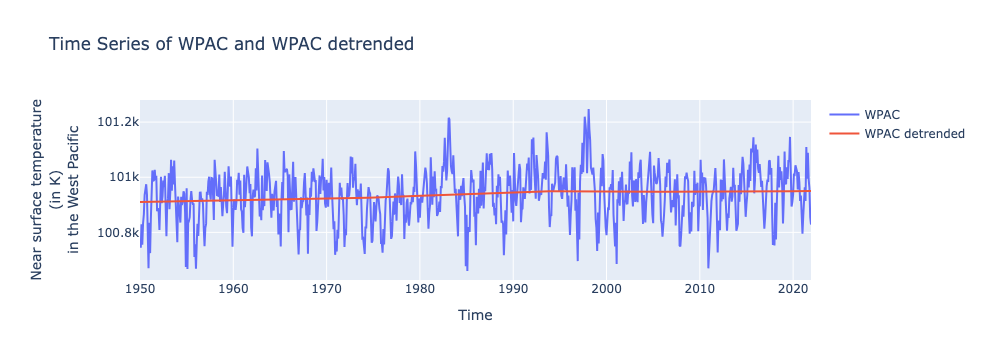

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=WPAC, mode='lines', name='WPAC'))
fig.add_trace(go.Scatter(x=time_index, y=WPAC_detrended, mode='lines', name='WPAC detrended'))
fig.update_layout(
    title='Time Series of WPAC and WPAC detrended',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the West Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

## Phillips-Perron Stationarity Test & Shapiro-Wilk Conditional Independence Test

After de-seasonalizing and de-trending our time series, we use the Phillips-Perron test (PhillipsPerron() function from arch.unitroot) to check if the remaining time series are stationary. This test allows for higher-order serial correlation in the residuals and is therefore suitable for the highly interdependent time series we analyse in this thesis. The null hypothesis is that the time series has a unit root, thus being non-stationary. The alternative hypothesis is that the time series is stationary.

Testing for conditional independence in both the PC and MCI step is done with the partial correlation test. As mentioned in Section 3.3.2, the assumptions governing this test are that the data is normally distributed and that there is a linear relation between them. 

First we make scatterplots and density plots to check these assumptions. To do so, we make a nice dataframe including column names of the variables. Note that we also deseazonalize and detrend the data.

In [39]:
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

df = pd.DataFrame(extended_data, columns=var_names)

cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
zws_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
nhf_detrend = deTrend_deSeasonalize(df['NHF'], show_plot = False)
        
df_extended = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})

Consequently, we make the scatterplots of the data.

<Figure size 1500x1500 with 0 Axes>

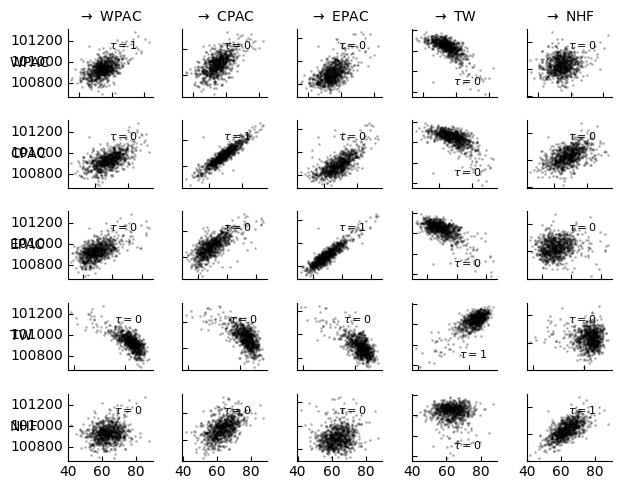

In [40]:
dataframe_extended = pp.DataFrame(np.copy(df_extended), datatime = {0:np.arange(len(df_extended))}, var_names= var_names)
fig = plt.figure(figsize=(15, 15))  
tp.plot_scatterplots(dataframe=dataframe_extended)
plt.show()

Finally, we also make the density plots of our detrended and deseazonalized data.

<Figure size 1500x1500 with 0 Axes>

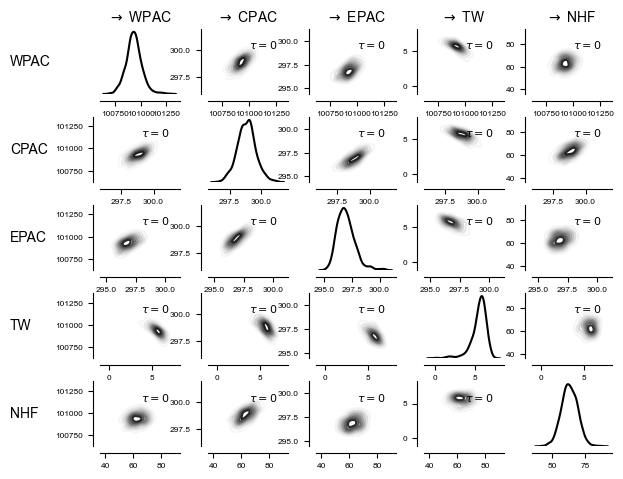

In [41]:
fig = plt.figure(figsize=(15, 15))
tp.plot_densityplots(dataframe=dataframe_extended)
plt.show()

In [42]:
from arch.unitroot import PhillipsPerron
from scipy import stats

Function to conduct the tests. I changed it a little bit from the code of Emma, because we already did the transformation on the data. The name is the same though.

In [43]:
def test_norm_stat(data):
    
    cpac_detrend = deTrend_deSeasonalize(data['CPAC'], show_plot = False)
    epac_detrend = deTrend_deSeasonalize(data['EPAC'], show_plot = False)
    wpac_detrend = deTrend_deSeasonalize(data['WPAC'], show_plot = False)
    tw_detrend = deTrend_deSeasonalize(data['TW'], show_plot = False)
    nhf_detrend = deTrend_deSeasonalize(data['NHF'], show_plot = False)
    
    df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': tw_detrend,
                                        'NHF': nhf_detrend})
    
    print('p-value PhillipsPerron test WPAC:', PhillipsPerron(wpac_detrend).pvalue)
    print('p-value PhillipsPerron test CPAC:', PhillipsPerron(cpac_detrend).pvalue)
    print('p-value PhillipsPerron test EPAC:', PhillipsPerron(epac_detrend).pvalue)
    print('p-value PhillipsPerron test TW:', PhillipsPerron(tw_detrend).pvalue)
    print('p-value PhillipsPerron test NHF:', PhillipsPerron(nhf_detrend).pvalue)
        
    print('p-value Shapiro-Wilk test WPAC:', stats.shapiro(wpac_detrend).pvalue)
    print('p-value Shapiro-Wilk test CPAC:', stats.shapiro(cpac_detrend).pvalue)
    print('p-value Shapiro-Wilk test EPAC:', stats.shapiro(epac_detrend).pvalue)
    print('p-value Shapiro-Wilk test TW:', stats.shapiro(tw_detrend).pvalue)
    print('p-value Shapiro-Wilk test NHF:', stats.shapiro(nhf_detrend).pvalue)

We can run this function to print the p-values for both the Phillips-Perron test (for stationarity) and the Shapiro-Wilk test (for conditional independence / normality). 

In [44]:
test_norm_stat(df)

p-value PhillipsPerron test WPAC: 0.0
p-value PhillipsPerron test CPAC: 2.562402779417995e-07
p-value PhillipsPerron test EPAC: 1.2023557483769288e-07
p-value PhillipsPerron test TW: 1.4647223885823739e-24
p-value PhillipsPerron test NHF: 1.983145317245735e-29
p-value Shapiro-Wilk test WPAC: 6.363729008300087e-09
p-value Shapiro-Wilk test CPAC: 0.059224604917031964
p-value Shapiro-Wilk test EPAC: 2.8711147339932404e-16
p-value Shapiro-Wilk test TW: 1.0071736623198781e-26
p-value Shapiro-Wilk test NHF: 0.277801011586317


In [45]:
def significance_test_norm_stat(data, alpha):
    cpac_detrend = deTrend_deSeasonalize(data['CPAC'], show_plot = False)
    epac_detrend = deTrend_deSeasonalize(data['EPAC'], show_plot = False)
    wpac_detrend = deTrend_deSeasonalize(data['WPAC'], show_plot = False)
    tw_detrend = deTrend_deSeasonalize(data['TW'], show_plot = False)
    nhf_detrend = deTrend_deSeasonalize(data['NHF'], show_plot = False)
        
    df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': tw_detrend,
                                        'NHF': nhf_detrend})
    p_values_pp = [PhillipsPerron(detrend).pvalue for detrend in [wpac_detrend, cpac_detrend, epac_detrend, tw_detrend, nhf_detrend]]
    p_values_sw = [stats.shapiro(detrend).pvalue for detrend in [wpac_detrend, cpac_detrend, epac_detrend, tw_detrend, nhf_detrend]]
    for var, p_pp, p_sw in zip(['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF'], p_values_pp, p_values_sw):
        if p_pp < alpha:
            print(f"PhillipsPerron test indicates normality for {var} (p-value < {alpha})")
        else:
            print(f"PhillipsPerron test indicates non-normality for {var} (p-value >= {alpha})")    
        if p_sw < alpha:
            print(f"Shapiro-Wilk test indicates normality for {var} (p-value < {alpha})")
        else:
            print(f"Shapiro-Wilk test indicates non-normality for {var} (p-value >= {alpha})")

In [46]:
significance_test_norm_stat(df, alpha_level)

PhillipsPerron test indicates normality for WPAC (p-value < 0.05)
Shapiro-Wilk test indicates normality for WPAC (p-value < 0.05)
PhillipsPerron test indicates normality for CPAC (p-value < 0.05)
Shapiro-Wilk test indicates non-normality for CPAC (p-value >= 0.05)
PhillipsPerron test indicates normality for EPAC (p-value < 0.05)
Shapiro-Wilk test indicates normality for EPAC (p-value < 0.05)
PhillipsPerron test indicates normality for TW (p-value < 0.05)
Shapiro-Wilk test indicates normality for TW (p-value < 0.05)
PhillipsPerron test indicates normality for NHF (p-value < 0.05)
Shapiro-Wilk test indicates non-normality for NHF (p-value >= 0.05)


The null hypothesis of this test is that the data is drawn from a normal distribution and we take α = 0.05 as the significance level. For all variables we find p-values that are smaller than the critical value of 0.05, so we can assume normality for all variables.

## Masking

We will mask the data. A mask is a binary indicator that specifies which data points are and which are not considered in the analysis, based on some criterion. It essentially creates a filter over the time series, indicating which observations should be included or excluded from analysis. We can include it directly in the partial correlation test of the Tigramite package. For clarity, on the Tigramite page it is explained that: "Conditional independence test used to test dependence between system nodes and dummy nodes. Currently, ParCorr is used with one-hot encoded dummies." Some more information about the test:

"Partial correlation is estimated through linear ordinary least squares (OLS) regression and a test for non-zero linear Pearson correlation on the residuals."
"confidence (str, optional (default: None)) – Specify type of confidence estimation. If False, numpy.nan is returned. ‘bootstrap’ can be used with any test, for ParCorr also ‘analytic’ is implemented. For the significance='analytic' Student’s-t distribution with T-D_Z-2 degrees of freedom is implemented."

"mask_type (str) – Must be in {None, ‘y’,’x’,’z’,’xy’,’xz’,’yz’,’xyz’} Masking mode: Indicators for which variables in the dependence measure I(X; Y | Z) the samples should be masked. If None, the mask is not used. Explained in tutorial on masking and missing values."

In [47]:
parcorr = ParCorr(significance='analytic', mask_type='y')

# Model

Time to build the model! We use the formula for robust links as given in Emma's code. Figure 21 shows the robust links in three-node network for reanalysis data.

## Model for model data

In [48]:
def link_robustness(data, parcorr, extended = 0, info = True, model = 'model'):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        data = data[:,:3]

        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dataframe = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)

        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        data = data[:,:4]

        
        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dataframe = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
        
        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': zws_detrend})
            
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dataframe = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df['NHF'], show_plot = False)
        
        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': zws_detrend, #This was 'ZWS' in Emma's code but changed it back 
                                        'NHF': nhf_detrend})
            
    # 1950-1980
    test1vroeg = df_processed[:360]
    # 1951-1982
    test2vroeg = df_processed[12:384]
    #1952-1979
    test3vroeg = df_processed[24:348]
    #1950-1982
    test4vroeg = df_processed[:384]
    # 1980-2010
    test1laat = df_processed[360:-48]
    # 1982-2013
    test2laat = df_processed[384:-12]
    #1981-2012
    test3laat = df_processed[372:-24]
    #1982-2014
    test4laat = df_processed[384:]
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test1vroeg), datatime = {0:np.arange(len(test1vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test1vroeg = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.01, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test2vroeg), datatime = {0:np.arange(len(test2vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test2vroeg = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test3vroeg), datatime = {0:np.arange(len(test3vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test3vroeg = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test4vroeg), datatime = {0:np.arange(len(test4vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test4vroeg = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test1laat), datatime = {0:np.arange(len(test1laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test1laat = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test2laat), datatime = {0:np.arange(len(test2laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test2laat = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test3laat), datatime = {0:np.arange(len(test3laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test3laat = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test4laat), datatime = {0:np.arange(len(test4laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test4laat = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    if info == True:
        ## PLOT ALL DAGS

        fig, axes = plt.subplots(4, 2, figsize=(8, 16), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_test1vroeg['val_matrix'],
            graph=results_test1vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,0]))
        axes[0,0].set_title('1950-1980')

        tp.plot_graph(
            val_matrix=results_test1laat['val_matrix'],
            graph=results_test1laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,1]))
        axes[0,1].set_title('1980-2010')

        tp.plot_graph(
            val_matrix=results_test2vroeg['val_matrix'],
            graph=results_test2vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,0]))
        axes[1,0].set_title('1951-1982')
        
        tp.plot_graph(
            val_matrix=results_test2laat['val_matrix'],
            graph=results_test2laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,1]))
        axes[1,1].set_title('1982-2013')
        
        tp.plot_graph(
            val_matrix=results_test3vroeg['val_matrix'],
            graph=results_test3vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,0]))
        axes[2,0].set_title('1952-1979')
        
        tp.plot_graph(
            val_matrix=results_test3laat['val_matrix'],
            graph=results_test3laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,1]))
        axes[2,1].set_title('1981-2012')
        
        tp.plot_graph(
            val_matrix=results_test4vroeg['val_matrix'],
            graph=results_test4vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,0]))
        axes[3,0].set_title('1950-1981')

        tp.plot_graph(
            val_matrix=results_test4laat['val_matrix'],
            graph=results_test4laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,1]))
        axes[3,1].set_title('1982-2014')

        fig.suptitle(f'Causal networks based on {model} data', fontsize = 18)
    
        plt.subplots_adjust(hspace=0.8)
        plt.show()
        
        return results_test1vroeg, results_test2vroeg, results_test3vroeg, results_test4vroeg, results_test1laat, results_test2laat, results_test3laat, results_test4laat

## Another function for the reanalysis data

In [1]:
# function that only takes spring barrier mask

def link_robustness_reanalysis(GFDL_data, parcorr, extended = 0, info = True, model = 'model', tau_max=3):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        GFDL_data = GFDL_data[:,:3]

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        GFDL_data = GFDL_data[:,:4]

        
        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend})
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    # 1950-1985
    test1vroeg = df_GFDL_processed[:420]
    # 1950-1980
    test2vroeg = df_GFDL_processed[:360]
    #1951-1983
    test3vroeg = df_GFDL_processed[12:396]
    #1950-1982
    test4vroeg = df_GFDL_processed[:384]
    # 1986-2020
    test1laat = df_GFDL_processed[420:840]
    # 1980-2010
    test2laat = df_GFDL_processed[360:-144]
    #1984-2016
    test3laat = df_GFDL_processed[396:-60]
    #1983-2014
    test4laat = df_GFDL_processed[385:-96]
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test1vroeg), datatime = {0:np.arange(len(test1vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test1vroeg = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.01, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test2vroeg), datatime = {0:np.arange(len(test2vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test2vroeg = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test3vroeg), datatime = {0:np.arange(len(test3vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test3vroeg = pcmci_GFDL.run_pcmci(tau_max=1, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test4vroeg), datatime = {0:np.arange(len(test4vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test4vroeg = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test1laat), datatime = {0:np.arange(len(test1laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test1laat = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test2laat), datatime = {0:np.arange(len(test2laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test2laat = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test3laat), datatime = {0:np.arange(len(test3laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test3laat = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test4laat), datatime = {0:np.arange(len(test4laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test4laat = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    if info == True:
        ## PLOT ALL DAGS

        fig, axes = plt.subplots(4, 2, figsize=(8, 16), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_test1vroeg['val_matrix'],
            graph=results_test1vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,0]))
        axes[0,0].set_title('1950-1985')

        tp.plot_graph(
            val_matrix=results_test1laat['val_matrix'],
            graph=results_test1laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,1]))
        axes[0,1].set_title('1986-2020')

        tp.plot_graph(
            val_matrix=results_test2vroeg['val_matrix'],
            graph=results_test2vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,0]))
        axes[1,0].set_title('1950-1980')
        
        tp.plot_graph(
            val_matrix=results_test2laat['val_matrix'],
            graph=results_test2laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,1]))
        axes[1,1].set_title('1980-2010')
        
        tp.plot_graph(
            val_matrix=results_test3vroeg['val_matrix'],
            graph=results_test3vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,0]))
        axes[2,0].set_title('1951-1983')
        
        tp.plot_graph(
            val_matrix=results_test3laat['val_matrix'],
            graph=results_test3laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,1]))
        axes[2,1].set_title('1984-2016')
        
        tp.plot_graph(
            val_matrix=results_test4vroeg['val_matrix'],
            graph=results_test4vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,0]))
        axes[3,0].set_title('1950-1981')

        tp.plot_graph(
            val_matrix=results_test4laat['val_matrix'],
            graph=results_test4laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,1]))
        axes[3,1].set_title('1982-2014')

        fig.suptitle(f'Causal networks based on {model} data', fontsize = 18)
    
        plt.subplots_adjust(hspace=0.8)
        plt.show()

        return results_test1vroeg, results_test2vroeg, results_test3vroeg, results_test4vroeg, results_test1laat, results_test2laat, results_test3laat, results_test4laat
    
    

# Graphs - Reanalysis Data

## Three Node Network

We can use the formula and specify how many nodes we want by simply adjusting 'extended' to equal 0 (which represents three nodes). 

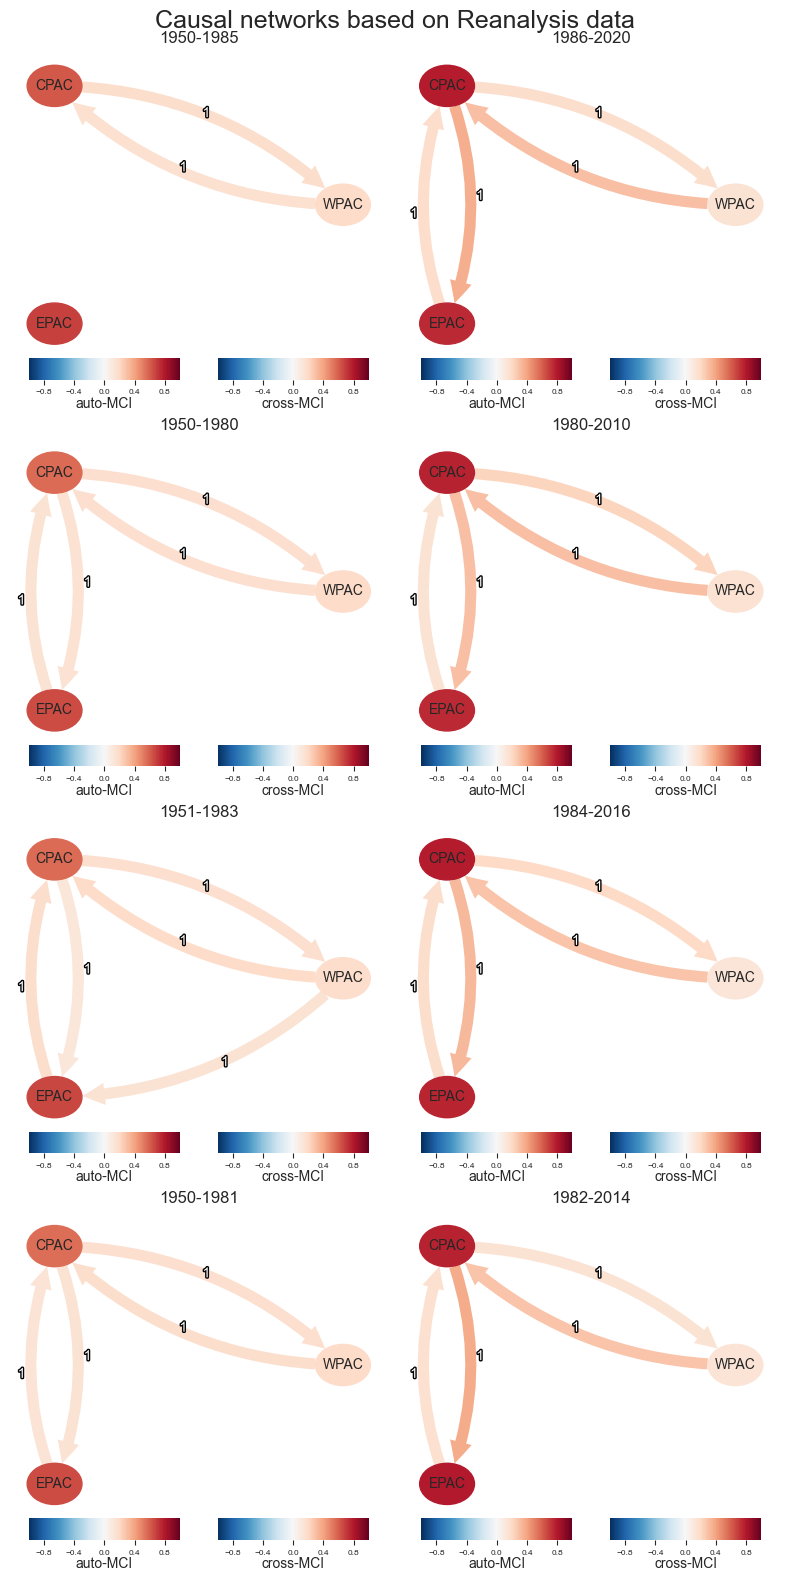

In [75]:
Reanalysis_3N_1vroeg, Reanalysis_3N_2vroeg, Reanalysis_3N_3vroeg, Reanalysis_3N_4vroeg, Reanalysis_3N_1laat, Reanalysis_3N_2laat, Reanalysis_3N_3laat, Reanalysis_3N_4laat = link_robustness_reanalysis(extended_data, parcorr, extended = 0, model = 'Reanalysis', tau_max=1)

## Four Node Network

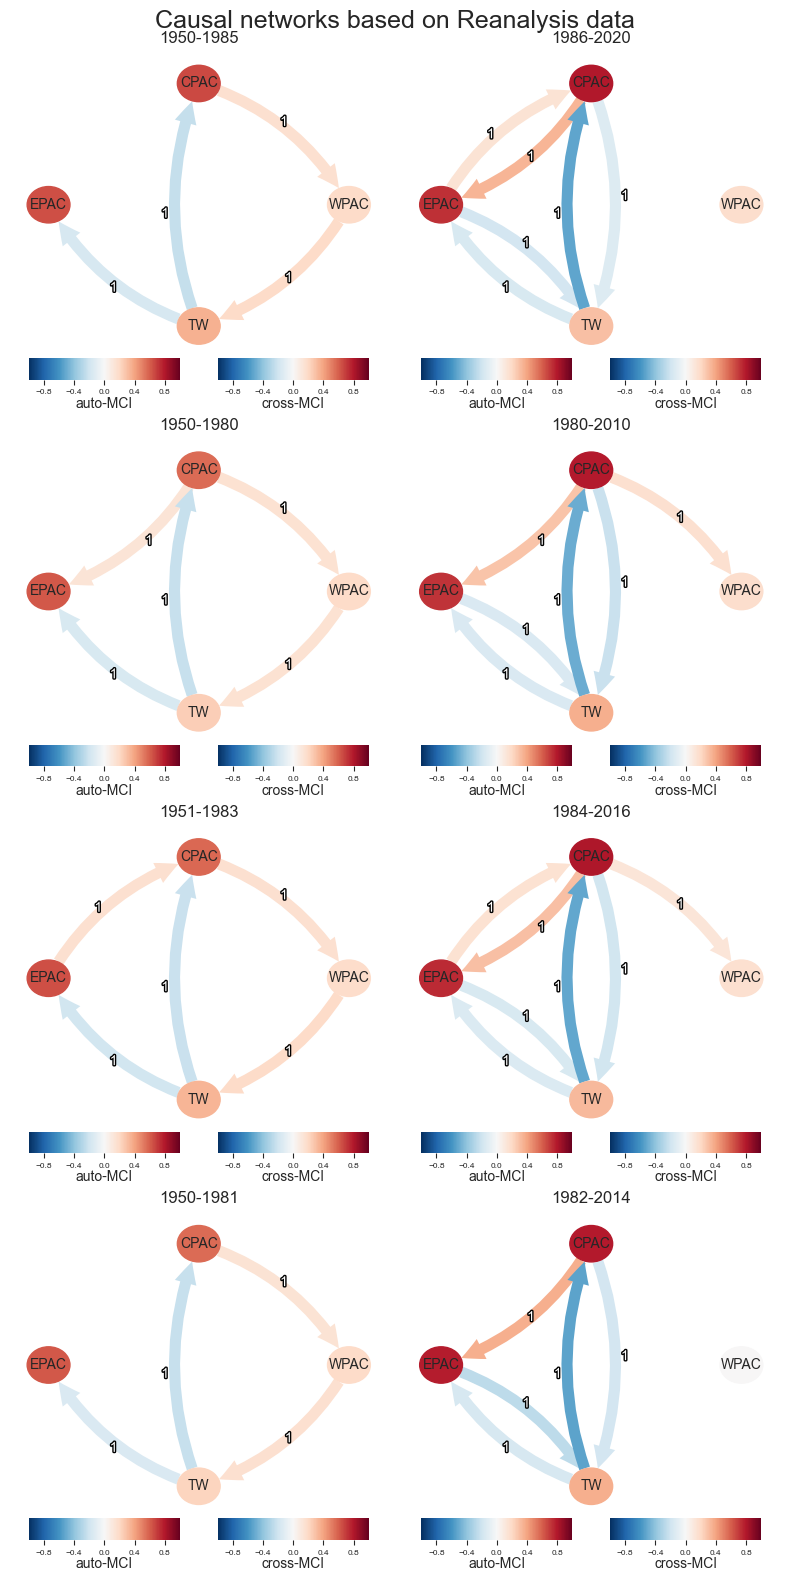

In [74]:
Reanalysis_4N_1vroeg, Reanalysis_4N_2vroeg, Reanalysis_4N_3vroeg, Reanalysis_4N_4vroeg, Reanalysis_4N_1laat, Reanalysis_4N_2laat, Reanalysis_4N_3laat, Reanalysis_4N_4laat = link_robustness_reanalysis(extended_data, parcorr, extended = 1, model = 'Reanalysis', tau_max=1)


## Five Node Network

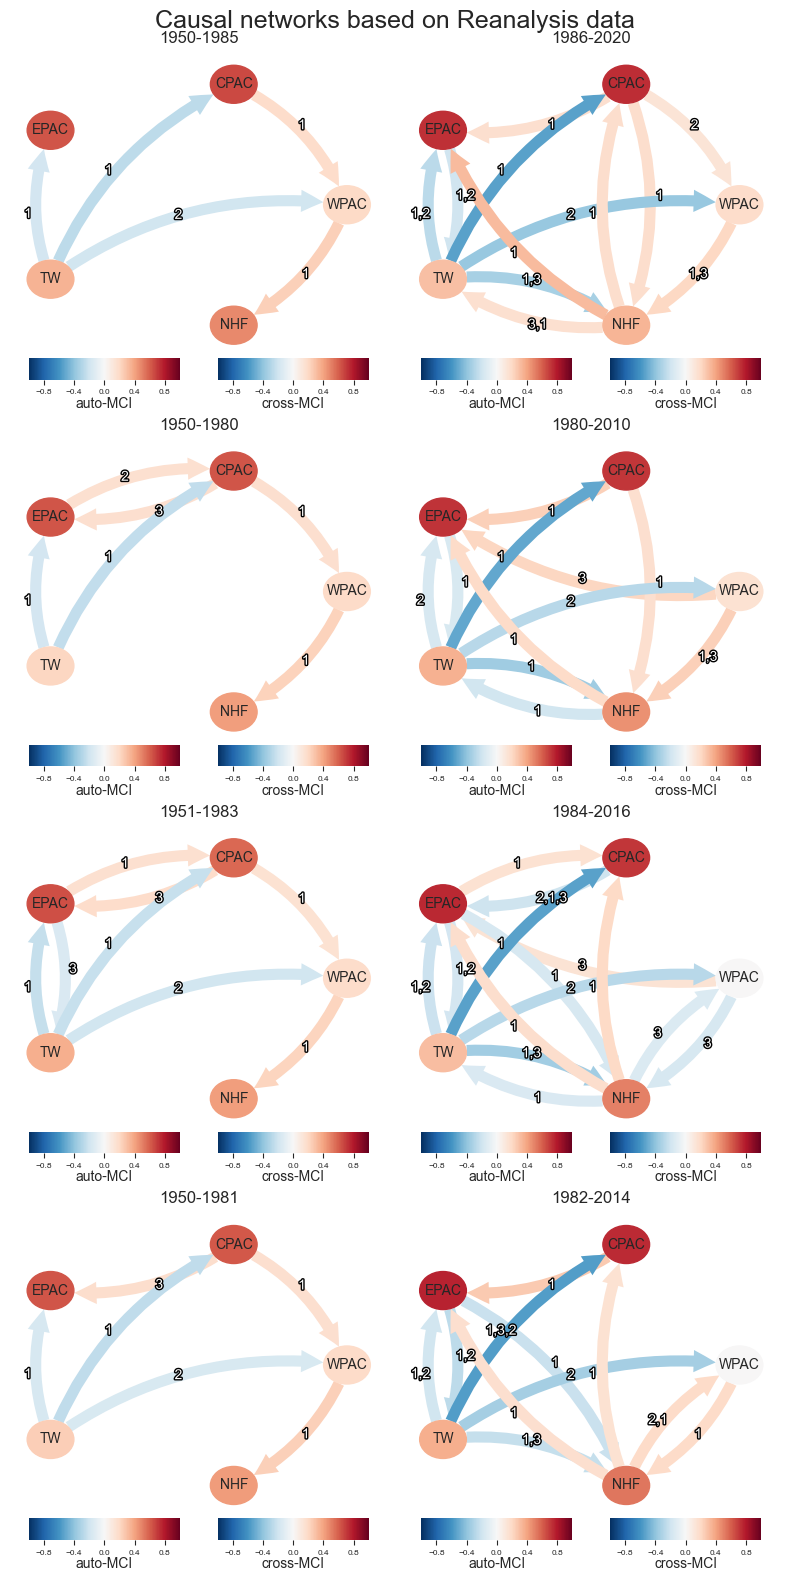

In [48]:
Reanalysis_5N_1vroeg, Reanalysis_5N_2vroeg, Reanalysis_5N_3vroeg, Reanalysis_5N_4vroeg, Reanalysis_5N_1laat, Reanalysis_5N_2laat, Reanalysis_5N_3laat, Reanalysis_5N_4laat = link_robustness_reanalysis(extended_data, parcorr, extended = 2, model = 'Reanalysis')

## Robust Links

Next up we will use Emma's function that will show only one graph with robust links, which we call our 'robust' graph. We call a link robust when it shows up in at least 3 of the graphs regarding that time period (early or late). Therefore, we define robust_links as being 3. I changed some things in the function to make it more general and easy to use it for all my graphs easily.

In [59]:
def robust_links_identifier(list_of_test_results, arrow_presence_int, vars):

    # get graphs from test results list
    graph_list = []
    for result in list_of_test_results:
        graph_list.append(result['graph'])
    
    # convert the '-->' entries to boolean values
    bool_arrays = [(arr == '-->') for arr in graph_list]
    
    # sum all values of the bool arrays to see what entries have more than arrow_presence_int '-->'
    sum_bool_arrays = np.sum(bool_arrays, axis = 0)
    
    # make new array where we place a '-->' if more than arrow_presence_int entry in sum_bool_arrays
    new_graph = np.where(sum_bool_arrays >= arrow_presence_int, '-->', '')

    var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS', 'NHF']
    var_names = var_names[:vars]

    tp.plot_graph(
                val_matrix=list_of_test_results[0]['val_matrix'],
                graph=new_graph,
                var_names=var_names,
                link_colorbar_label='cross-MCI',
                node_colorbar_label='auto-MCI')
    
    return new_graph

def robust_links_identifier_2(list_of_test_results_early, list_of_test_results_late, arrow_presence_int, vars, model = 'Reanalysis'):

    var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS', 'NHF']
    var_names = var_names[:vars]
    
    #EARLY
    # get graphs from test results list
    graph_list_early = []
    for result in list_of_test_results_early:
        graph_list_early.append(result['graph'])
    
    # convert the '-->' entries to boolean values
    bool_arrays_early = [(arr == '-->') for arr in graph_list_early]
    
    # sum all values of the bool arrays to see what entries have more than arrow_presence_int '-->'
    sum_bool_arrays_early = np.sum(bool_arrays_early, axis = 0)
    
    # make new array where we place a '-->' if more than arrow_presence_int entry in sum_bool_arrays
    new_graph_early = np.where(sum_bool_arrays_early >= arrow_presence_int, '-->', '')

    #LATE
    # get graphs from test results list
    graph_list_late = []
    for result in list_of_test_results_late:
        graph_list_late.append(result['graph'])
    
    # convert the '-->' entries to boolean values
    bool_arrays_late = [(arr == '-->') for arr in graph_list_late]
    
    # sum all values of the bool arrays to see what entries have more than arrow_presence_int '-->'
    sum_bool_arrays_late = np.sum(bool_arrays_late, axis = 0)
    
    # make new array where we place a '-->' if more than arrow_presence_int entry in sum_bool_arrays
    new_graph_late = np.where(sum_bool_arrays_late >= arrow_presence_int, '-->', '')
    
    val_matrix_early = list_of_test_results_early[0]['val_matrix']
    val_matrix_late = list_of_test_results_late[0]['val_matrix']
    conf_matrix_early = list_of_test_results_late[0]['conf_matrix']
    
    # plot the graph
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
    tp.plot_graph(
                val_matrix=val_matrix_early,
                graph=new_graph_early,
                var_names=var_names,
                link_colorbar_label='cross-MCI',
                node_colorbar_label='auto-MCI',
                fig_ax=(fig, axes[0]))  # Assigning to the first subplot
    axes[0].set_title('1950-1982')
    tp.plot_graph(
                val_matrix=val_matrix_late,
                graph=new_graph_late,
                var_names=var_names,
                link_colorbar_label='cross-MCI',
                node_colorbar_label='auto-MCI',
                fig_ax=(fig, axes[1]))  # Assigning to the second subplot
    axes[1].set_title('1982-2014')
    fig.suptitle(f'Causal networks based on {model} data', fontsize = 18)
    plt.subplots_adjust(hspace=0.8)
    plt.show()
    
    return val_matrix_early, val_matrix_late, conf_matrix_early

In [51]:
robust_links = 3

### Three Node Robust Network

Using the stored data from the PCMCI analysis from the model above, we can construct the robust links. The robust networks for the early and late stage for the three node network are given below.

In [76]:
Reanalysis_3N_Vroeg = Reanalysis_3N_1vroeg, Reanalysis_3N_2vroeg, Reanalysis_3N_3vroeg, Reanalysis_3N_4vroeg
Reanalysis_3N_Laat = Reanalysis_3N_1laat, Reanalysis_3N_2laat, Reanalysis_3N_3laat, Reanalysis_3N_4laat

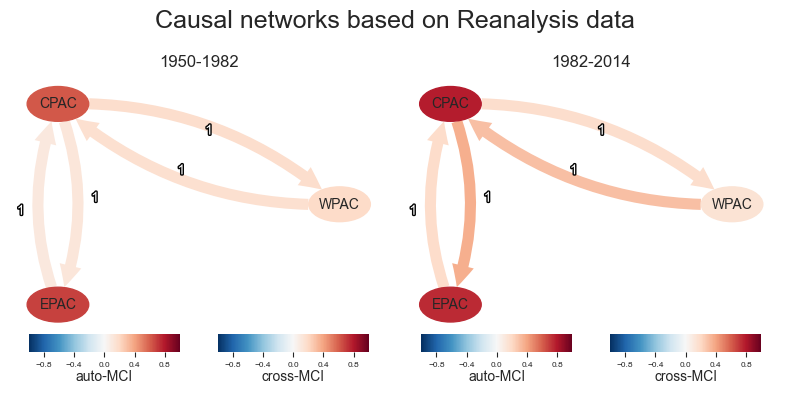

[[[[ 0.          0.        ]
   [ 0.05534046  0.23681381]]

  [[ 0.          0.        ]
   [ 0.21881737  0.38114596]]

  [[ 0.          0.        ]
   [ 0.00188125  0.18685316]]]


 [[[ 0.          0.        ]
   [ 0.08233397  0.26123121]]

  [[ 0.          0.        ]
   [ 0.76365042  0.80781885]]

  [[ 0.          0.        ]
   [ 0.27989124  0.43218233]]]


 [[[ 0.          0.        ]
   [-0.0281478   0.1578509 ]]

  [[ 0.          0.        ]
   [ 0.08834713  0.26668649]]

  [[ 0.          0.        ]
   [ 0.71735218  0.77271177]]]]
[[[0.         0.14794028]
  [0.         0.30327037]
  [0.         0.09560224]]

 [[0.         0.17392941]
  [0.         0.78724142]
  [0.         0.3596148 ]]

 [[0.         0.06570573]
  [0.         0.17972597]
  [0.         0.74696334]]]


In [81]:
val_matrix_early, val_matrix_late, conf_matrix_early = robust_links_identifier_2(Reanalysis_3N_Vroeg, Reanalysis_3N_Laat, robust_links, 3)
print(conf_matrix_early)
print(val_matrix_late)

In [79]:
significant_increase, significant_decrease, increase, decrease, other = CheckLinkStrengthening(val_matrix_early, val_matrix_late, conf_matrix_early)
print(significant_increase)
print(significant_decrease)
print(increase)
print(decrease)
print(other)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Four Node Robust Network

Using the stored data from the PCMCI analysis from the model above, we can construct the robust links. The robust networks for the early and late stage for the four node network are given below.

In [72]:
Reanalysis_4N_Vroeg = Reanalysis_4N_1vroeg, Reanalysis_4N_2vroeg, Reanalysis_4N_3vroeg, Reanalysis_4N_4vroeg
Reanalysis_4N_Laat = Reanalysis_4N_1laat, Reanalysis_4N_2laat, Reanalysis_4N_3laat, Reanalysis_4N_4laat

In [73]:
early_val, late_val, early_conf = robust_links_identifier_2(Reanalysis_4N_Vroeg, Reanalysis_4N_Laat, robust_links, 4)

/Users/juliette/anaconda3/envs/envEmma/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: could not broadcast input array from shape (4,4,4) into shape (4,4)

In [62]:
print(early_val)

[[[ 0.          0.19184717]
  [ 0.          0.09119714]
  [ 0.         -0.0116727 ]
  [ 0.          0.19219543]]

 [[ 0.          0.16249345]
  [ 0.          0.66290547]
  [ 0.          0.12793555]
  [ 0.         -0.10941008]]

 [[ 0.         -0.00754236]
  [ 0.          0.09989935]
  [ 0.          0.64187218]
  [ 0.         -0.08694992]]

 [[ 0.          0.02469044]
  [ 0.         -0.23610449]
  [ 0.         -0.16910679]
  [ 0.          0.35933584]]]


In [63]:
print(late_val)

[[[ 0.          0.17479871]
  [ 0.          0.00683406]
  [ 0.          0.00824547]
  [ 0.          0.11344058]]

 [[ 0.          0.09025327]
  [ 0.          0.80009549]
  [ 0.          0.33930371]
  [ 0.         -0.13500337]]

 [[ 0.          0.06152199]
  [ 0.          0.14145037]
  [ 0.          0.73247192]
  [ 0.         -0.18474738]]

 [[ 0.         -0.05101191]
  [ 0.         -0.52351233]
  [ 0.         -0.15802812]
  [ 0.          0.29760228]]]


In [64]:
print(early_conf)

[[[[ 0.          0.        ]
   [ 0.08323513  0.26204984]]

  [[ 0.          0.        ]
   [-0.08684342  0.10033236]]

  [[ 0.          0.        ]
   [-0.0855998   0.10187386]]

  [[ 0.          0.        ]
   [ 0.02001271  0.20395911]]]


 [[[ 0.          0.        ]
   [-0.0032307   0.18141583]]

  [[ 0.          0.        ]
   [ 0.77839367  0.81905414]]

  [[ 0.          0.        ]
   [ 0.25768791  0.41392606]]

  [[ 0.          0.        ]
   [-0.22438621 -0.0422061 ]]]


 [[[ 0.          0.        ]
   [-0.03235129  0.15379401]]

  [[ 0.          0.        ]
   [ 0.04866841  0.23065603]]

  [[ 0.          0.        ]
   [ 0.7005625   0.76019067]]

  [[ 0.          0.        ]
   [-0.27154301 -0.09341218]]]


 [[[ 0.          0.        ]
   [-0.14373125  0.04304256]]

  [[ 0.          0.        ]
   [-0.57807803 -0.4616537 ]]

  [[ 0.          0.        ]
   [-0.24636481 -0.06573569]]

  [[ 0.          0.        ]
   [ 0.2125924   0.37608875]]]]


In [65]:
def CheckLinkStrengthening(early_val_matrix, early_conf_matrix, late_val_matrix):
    
    n, _, _ = early_val_matrix.shape # Or just fill in 4
    
    decrease = 0
    significant_decrease = 0
    increase = 0
    significant_increase = 0
    other = 0
    
    for i in range(0,n): 
        for j in range(0,n): 
            before = early_val_matrix[j,i,1]
            after = late_val_matrix[j,i,1]
            if before > after:
                decrease += 1
                if after < early_conf_matrix[j,i,1,0]:
                    significant_decrease += 1
            elif before < after: 
                increase += 1
                if after > early_conf_matrix[j,i,1,1]:
                    significant_increase += 1
            else: 
                other += 1
    
    return significant_increase, significant_decrease, increase, decrease, other

In [67]:
significant_increase, significant_decrease, increase, decrease, other = CheckLinkStrengthening(early_val, early_conf, late_val)
print(significant_increase)
print(significant_decrease)
print(increase)
print(decrease)
print(other)


0
0
7
9
0


### Five Network Robust Network

Using the stored data from the PCMCI analysis from the model above, we can construct the robust links. The robust networks for the early and late stage for the five node network are given below.

In [55]:
Reanalysis_5N_Vroeg = Reanalysis_5N_1vroeg, Reanalysis_5N_2vroeg, Reanalysis_5N_3vroeg, Reanalysis_5N_4vroeg
Reanalysis_5N_Laat = Reanalysis_5N_1laat, Reanalysis_5N_2laat, Reanalysis_5N_3laat, Reanalysis_5N_4laat

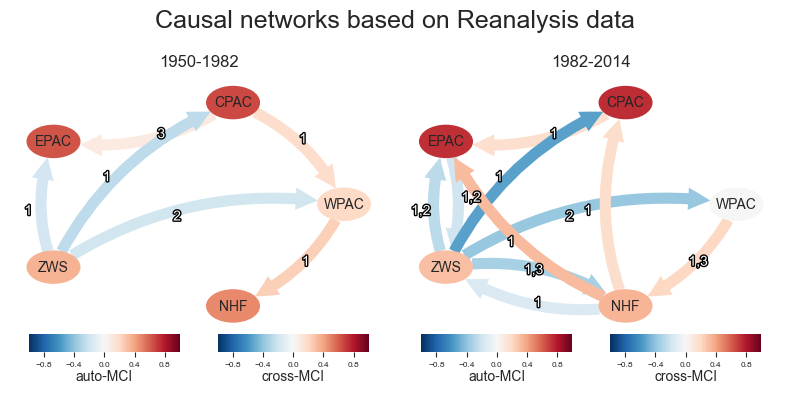

In [56]:
robust_links_identifier_2(Reanalysis_5N_Vroeg, Reanalysis_5N_Laat, robust_links, 5)

# Graphs - Model Data

To compare the reanalysis data causal networks to other models, we construct the same DAGs but using our two chosen models. Following Emma's reasoning from her thesis, we will only compare four-node networks.

## MIROC6

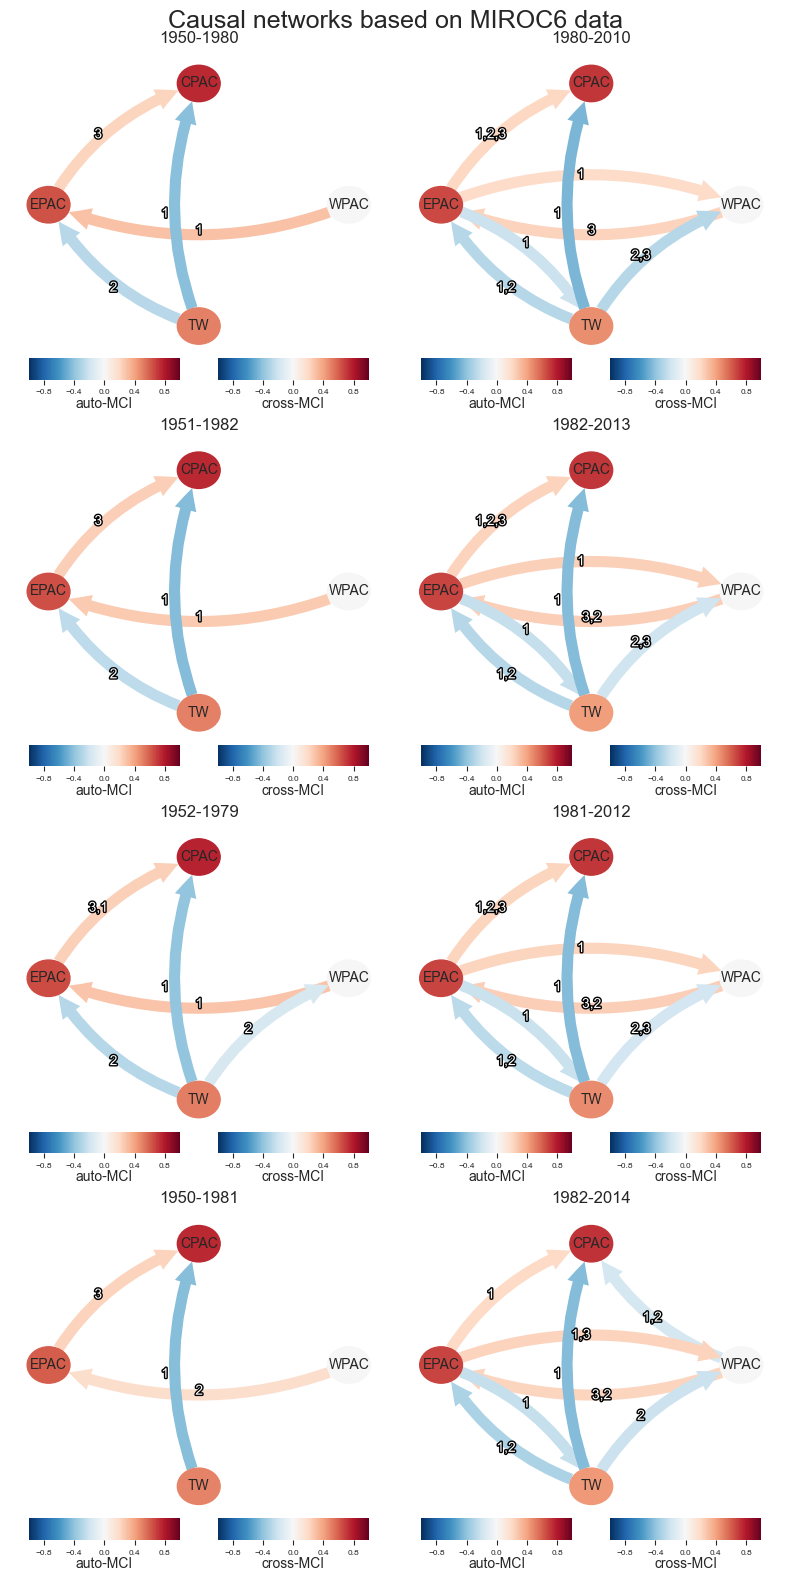

In [57]:
MIROC6_1vroeg, MIROC6_2vroeg, MIROC6_3vroeg, MIROC6_4vroeg, MIROC6_1laat, MIROC6_2laat, MIROC6_3laat, MIROC6_4laat = link_robustness(MIROC6_data_final, parcorr, extended = 1, model = 'MIROC6')

### Robustness using the function

Only the robust network of four nodes:

In [58]:
MIROC6_Vroeg = MIROC6_1vroeg, MIROC6_2vroeg, MIROC6_3vroeg, MIROC6_4vroeg
MIROC6_Laat = MIROC6_1laat, MIROC6_2laat, MIROC6_3laat, MIROC6_4laat

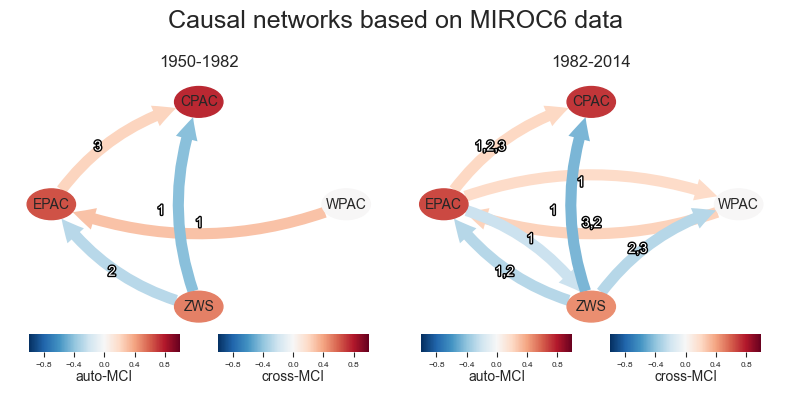

In [59]:
robust_links_identifier_2(MIROC6_Vroeg, MIROC6_Laat, robust_links, 4, model='MIROC6')

### Robustness using the drawing of graphs

In Emma's thesis she uses the following approach to find/plot the robust graphs.

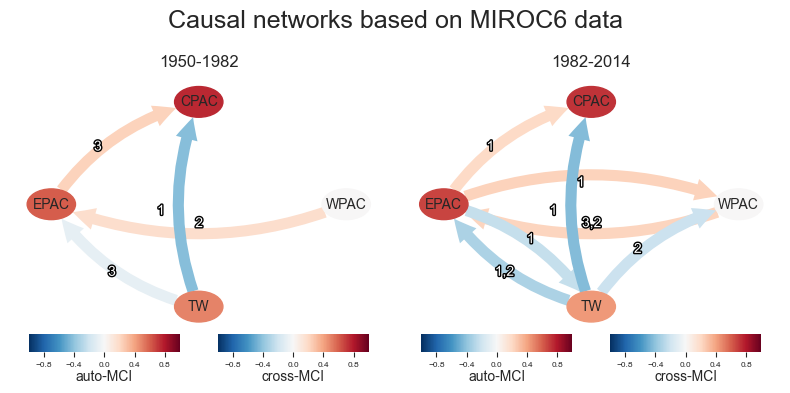

In [60]:
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']

graph_vroeg_fournode_MIROC6 = np.array([[['', '', '', ''],
        ['', '', '', ''],
        ['', '', '-->', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', '-->'],
        ['', '-->', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '-->'],
        ['', '-->', '-->', '']]], dtype='<U3')

graph_laat_fournode_MIROC6 = np.array([[['', '', '', ''],
        ['', '', '', ''],
        ['', '', '-->', '-->'],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', '-->'],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', '']],

       [['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
tp.plot_graph(
            val_matrix=MIROC6_4vroeg['val_matrix'],
            graph=graph_vroeg_fournode_MIROC6,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
axes[0].set_title('1950-1982')

tp.plot_graph(
            val_matrix=MIROC6_4laat['val_matrix'],
            graph=graph_laat_fournode_MIROC6,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1]))
axes[1].set_title('1982-2014')

fig.suptitle(f'Causal networks based on MIROC6 data', fontsize = 18)
    
plt.subplots_adjust(hspace=0.8)
plt.show()

## EC-Earth3

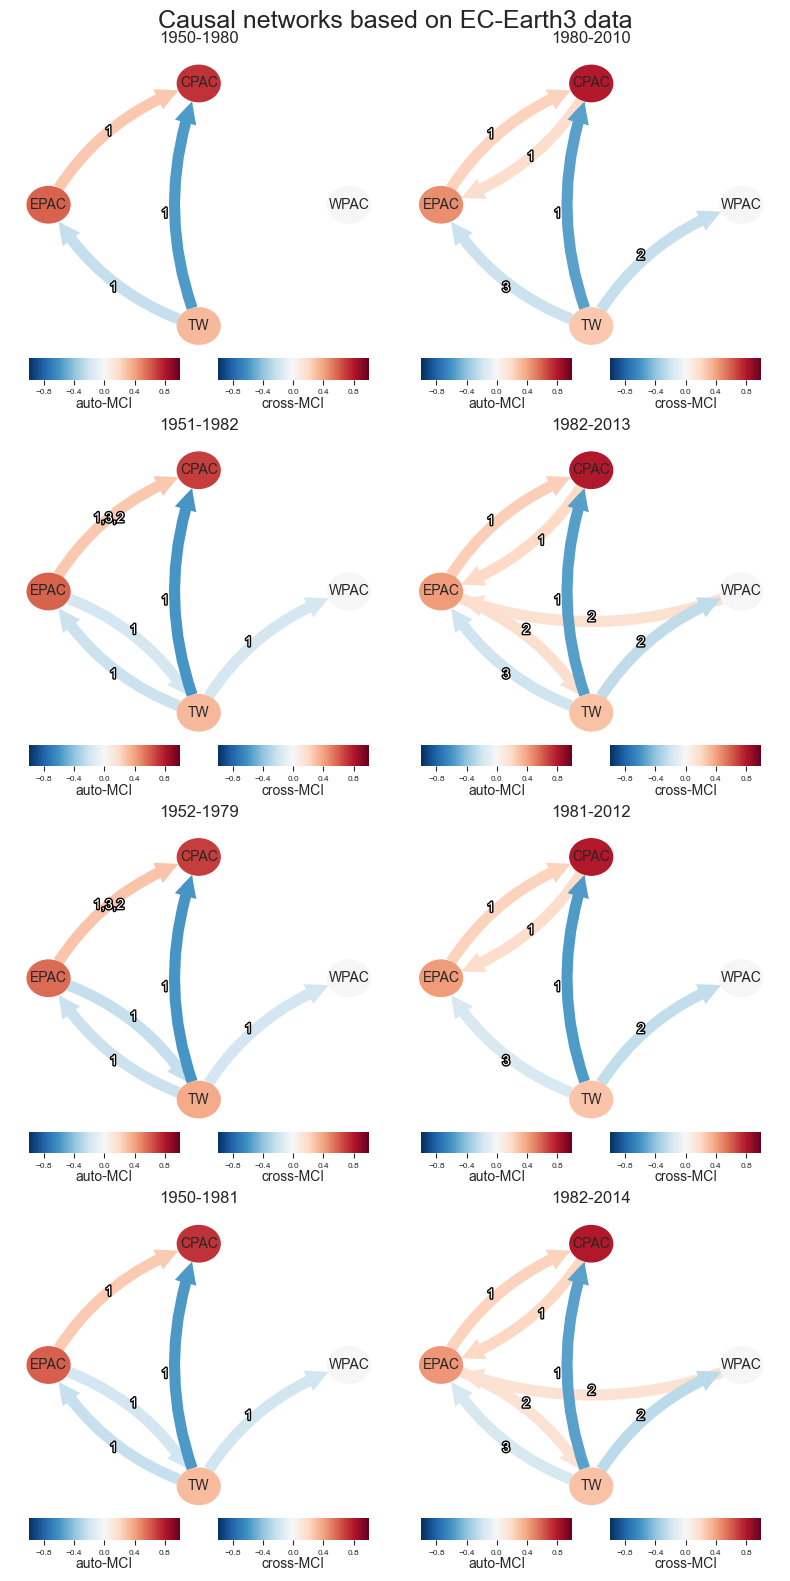

In [61]:
ECearth3_1vroeg, ECearth3_2vroeg, ECearth3_3vroeg, ECearth3_4vroeg, ECearth3_1laat, ECearth3_2laat, ECearth3_3laat, ECearth3_4laat = link_robustness(ECearth_data_final, parcorr, extended = 1, model = 'EC-Earth3')

### Robustness using the function

In [62]:
ECearth3_Vroeg = ECearth3_1vroeg, ECearth3_2vroeg, ECearth3_3vroeg, ECearth3_4vroeg
ECearth3_Laat = ECearth3_1laat, ECearth3_2laat, ECearth3_3laat, ECearth3_4laat

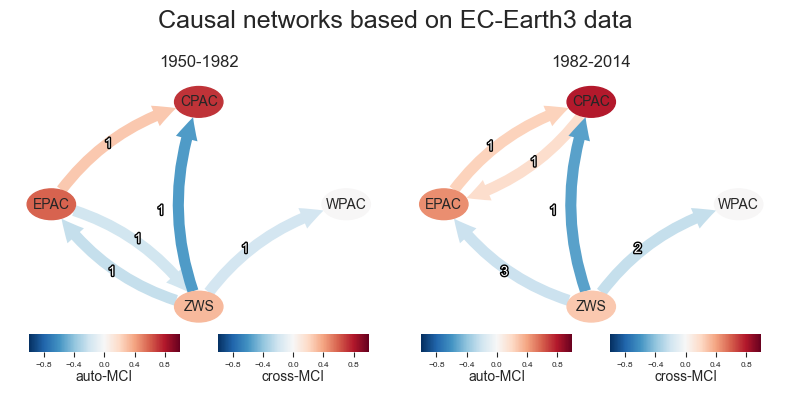

In [63]:
robust_links_identifier_2(ECearth3_Vroeg, ECearth3_Laat, robust_links, 4, model='EC-Earth3')

### Robustness using the drawing of graphs

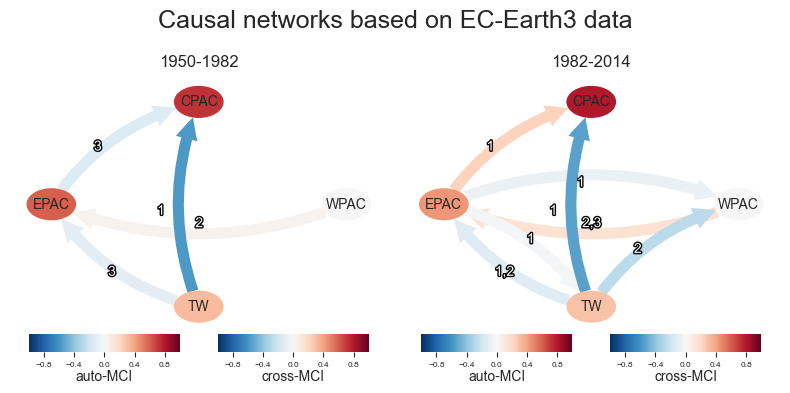

In [64]:
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']

graph_vroeg_fournode_ECearth3 = np.array([[['', '', '', ''],
        ['', '', '', ''],
        ['', '', '-->', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', '-->'],
        ['', '-->', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '-->'],
        ['', '-->', '-->', '']]], dtype='<U3')

graph_laat_fournode_ECearth3 = np.array([[['', '', '', ''],
        ['', '', '', ''],
        ['', '', '-->', '-->'],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', '-->'],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', '']],

       [['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
tp.plot_graph(
            val_matrix=ECearth3_4vroeg['val_matrix'],
            graph=graph_vroeg_fournode_ECearth3,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
axes[0].set_title('1950-1982')

tp.plot_graph(
            val_matrix=ECearth3_4laat['val_matrix'],
            graph=graph_laat_fournode_ECearth3,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1]))
axes[1].set_title('1982-2014')

fig.suptitle(f'Causal networks based on EC-Earth3 data', fontsize = 18)
    
plt.subplots_adjust(hspace=0.8)
plt.show()

# Parameterized test

In [65]:
def link_robustness_new(data, tau_max, tau_min, pc_alpha, alpha_level, parcorr, extended=0, info=True, model='model'):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        data = data[:,:3]

        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dataframe = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)

        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        data = data[:,:4]

        
        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dataframe = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
        
        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': zws_detrend})
            
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df = pd.DataFrame(data, columns=var_names)
        dataframe = pp.DataFrame(data, 
                                 datatime = np.arange(len(data)), 
                                 var_names=var_names)

        cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
        epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
        wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df['NHF'], show_plot = False)
        
        df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'TW': zws_detrend, #This was 'ZWS' in Emma's code but changed it back 
                                        'NHF': nhf_detrend})
            
    # 1950-1980
    test1vroeg = df_processed[:360]
    # 1951-1982
    test2vroeg = df_processed[12:384]
    #1952-1979
    test3vroeg = df_processed[24:348]
    #1950-1982
    test4vroeg = df_processed[:384]
    # 1980-2010
    test1laat = df_processed[360:-48]
    # 1982-2013
    test2laat = df_processed[384:-12]
    #1981-2012
    test3laat = df_processed[372:-24]
    #1982-2014
    test4laat = df_processed[384:]
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test1vroeg), datatime = {0:np.arange(len(test1vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test1vroeg = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test2vroeg), datatime = {0:np.arange(len(test2vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test2vroeg = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test3vroeg), datatime = {0:np.arange(len(test3vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test3vroeg = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test4vroeg), datatime = {0:np.arange(len(test4vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test4vroeg = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test1laat), datatime = {0:np.arange(len(test1laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test1laat = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test2laat), datatime = {0:np.arange(len(test2laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test2laat = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test3laat), datatime = {0:np.arange(len(test3laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test3laat = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe = pp.DataFrame(np.copy(test4laat), datatime = {0:np.arange(len(test4laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=0)
    results_test4laat = pcmci.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level, fdr_method = 'fdr_bh')
    
    if info == True:
        ## PLOT ALL DAGS

        fig, axes = plt.subplots(4, 2, figsize=(8, 16), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_test1vroeg['val_matrix'],
            graph=results_test1vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,0]))
        axes[0,0].set_title('1950-1980')

        tp.plot_graph(
            val_matrix=results_test1laat['val_matrix'],
            graph=results_test1laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,1]))
        axes[0,1].set_title('1980-2010')

        tp.plot_graph(
            val_matrix=results_test2vroeg['val_matrix'],
            graph=results_test2vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,0]))
        axes[1,0].set_title('1951-1982')
        
        tp.plot_graph(
            val_matrix=results_test2laat['val_matrix'],
            graph=results_test2laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,1]))
        axes[1,1].set_title('1982-2013')
        
        tp.plot_graph(
            val_matrix=results_test3vroeg['val_matrix'],
            graph=results_test3vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,0]))
        axes[2,0].set_title('1952-1979')
        
        tp.plot_graph(
            val_matrix=results_test3laat['val_matrix'],
            graph=results_test3laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,1]))
        axes[2,1].set_title('1981-2012')
        
        tp.plot_graph(
            val_matrix=results_test4vroeg['val_matrix'],
            graph=results_test4vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,0]))
        axes[3,0].set_title('1950-1981')

        tp.plot_graph(
            val_matrix=results_test4laat['val_matrix'],
            graph=results_test4laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,1]))
        axes[3,1].set_title('1982-2014')

        fig.suptitle(f'Causal networks based on {model} data', fontsize = 18)
    
        plt.subplots_adjust(hspace=0.8)
        plt.show()
        
        return results_test1vroeg, results_test2vroeg, results_test3vroeg, results_test4vroeg, results_test1laat, results_test2laat, results_test3laat, results_test4laat

## EC-Earth

In [66]:
print(tau_max, tau_min, pc_alpha, alpha_level)

3 1 0.05 0.05


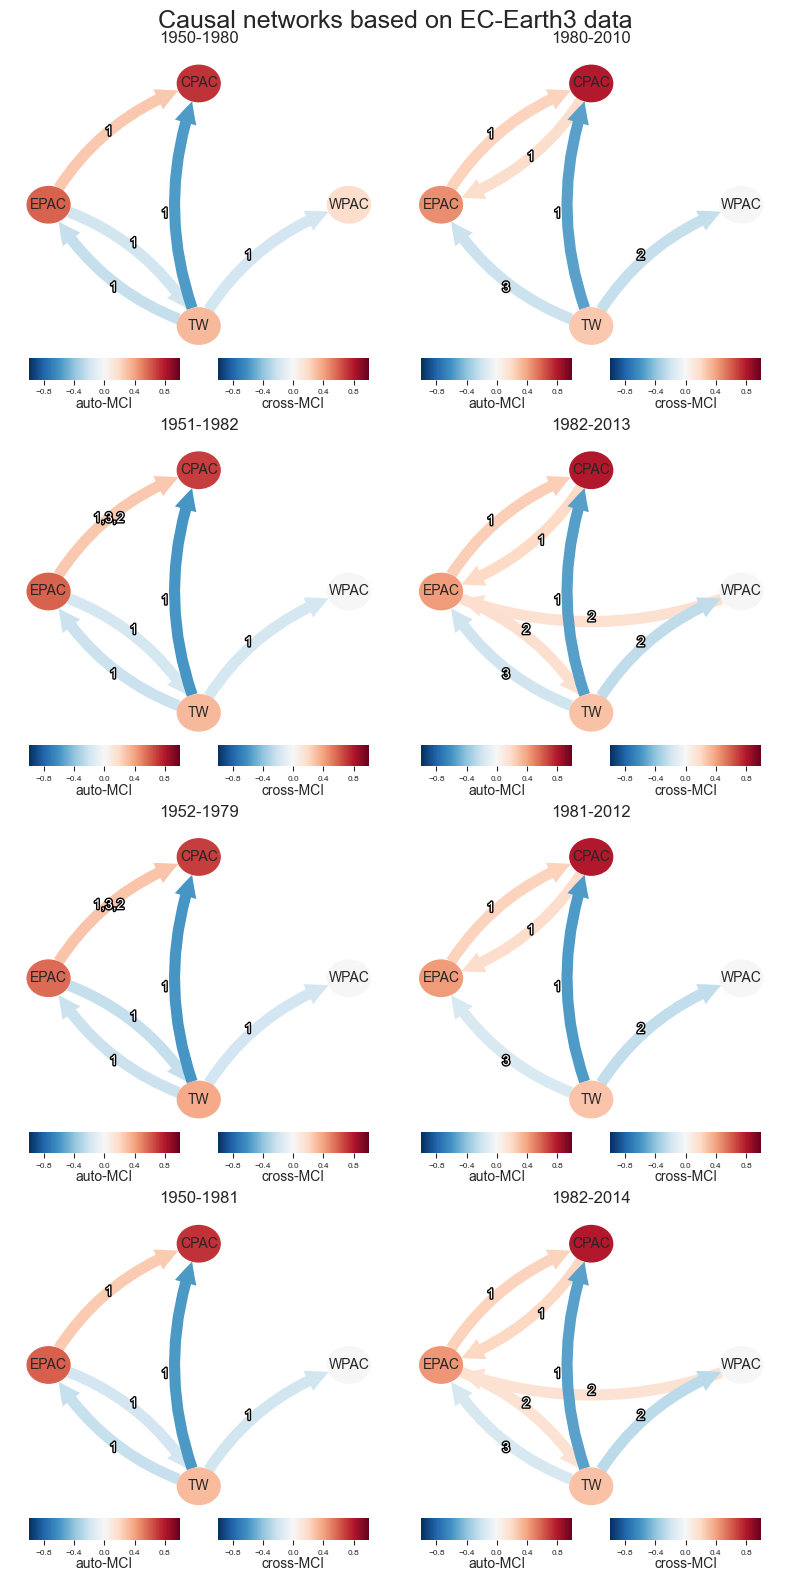

In [67]:
ECearth3_1vroeg, ECearth3_2vroeg, ECearth3_3vroeg, ECearth3_4vroeg, ECearth3_1laat, ECearth3_2laat, ECearth3_3laat, ECearth3_4laat = link_robustness_new(ECearth_data_final, tau_max, tau_min, pc_alpha, alpha_level, parcorr, extended = 1, model = 'EC-Earth3')

# Graphs - Complete history

To further inspect the data we also plot the DAGs for the complete history of observations.

In [68]:
def link_robustness_complete_reanalysis(GFDL_data, parcorr, tau_max=3, tau_min=1, extended = 0, info = True, model = 'model'):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        GFDL_data = GFDL_data[:,:3]

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        GFDL_data = GFDL_data[:,:4]

        
        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend})
            
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})
            
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=0.05, alpha_level=0.01, fdr_method = 'fdr_bh')
    
    # Plot the graph
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI')
    plt.title(f'Causal networks based on complete history of {model} data', fontsize = 18)
    plt.show()
    
    return results

## Three Node Complete History Network

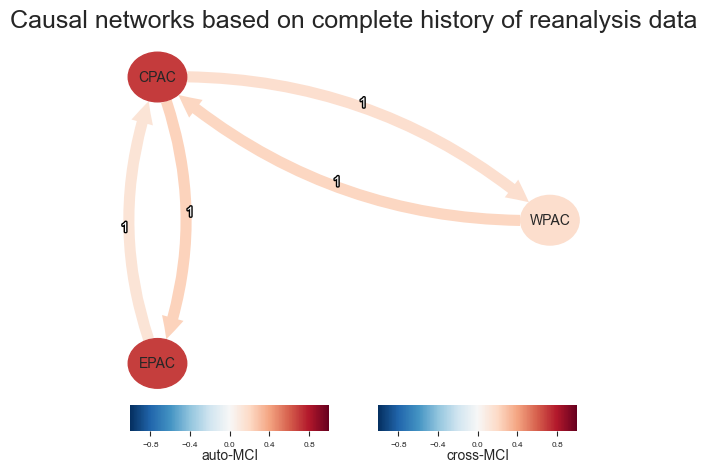

{'graph': array([[['', '-->'],
         ['', '-->'],
         ['', '']],
 
        [['', '-->'],
         ['', '-->'],
         ['', '-->']],
 
        [['', ''],
         ['', '-->'],
         ['', '-->']]], dtype='<U3'),
 'p_matrix': array([[[1.00000000e+00, 1.71849605e-05],
         [1.00000000e+00, 1.04533576e-07],
         [1.00000000e+00, 1.58578822e-02]],
 
        [[1.00000000e+00, 3.99468716e-05],
         [1.00000000e+00, 4.73137703e-93],
         [1.00000000e+00, 6.03029385e-09]],
 
        [[1.00000000e+00, 1.59571749e-01],
         [1.00000000e+00, 6.58391619e-04],
         [1.00000000e+00, 7.90619552e-93]]]),
 'val_matrix': array([[[0.        , 0.17373507],
         [0.        , 0.21358373],
         [0.        , 0.09684454]],
 
        [[0.        , 0.16496535],
         [0.        , 0.69565499],
         [0.        , 0.23367109]],
 
        [[0.        , 0.05553272],
         [0.        , 0.13663795],
         [0.        , 0.6934885 ]]]),
 'conf_matrix': array([[[[ 0.  

In [69]:
link_robustness_complete_reanalysis(extended_data, ParCorr(), tau_max=1, tau_min=1, extended = 0, info = True, model = 'reanalysis')

## Four Node Complete History Network

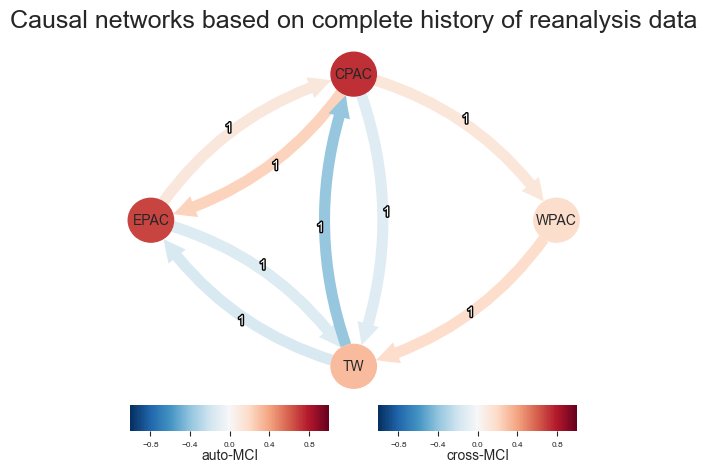

In [70]:
four_node_complete_history_reanalysis_results = link_robustness_complete_reanalysis(extended_data, ParCorr(), tau_max=1, tau_min=1, extended = 1, info = True, model = 'reanalysis')

In [78]:
values = four_node_complete_history_reanalysis_results['val_matrix']
print(values[1,3,1])

-0.12399532271326605
[[1.007654e+05 2.977563e+02 2.966236e+02 6.193619e+00 6.411725e+01]
 [1.007447e+05 2.978752e+02 2.977186e+02 6.642407e+00 5.421315e+01]
 [1.008298e+05 2.985520e+02 2.979710e+02 5.747903e+00 5.163650e+01]
 ...
 [1.009609e+05 2.977851e+02 2.954964e+02 5.994689e+00 6.706300e+01]
 [1.008551e+05 2.977210e+02 2.954913e+02 6.632870e+00 7.639825e+01]
 [1.008284e+05 2.978257e+02 2.957404e+02 6.947123e+00 6.295330e+01]]


In [79]:
#print(four_node_complete_history_reanalysis_results)
confidence_intervals = four_node_complete_history_reanalysis_results['conf_matrix']
print(confidence_intervals)

[[[[ 0.          0.        ]
   [ 0.11062203  0.23477964]]

  [[ 0.          0.        ]
   [ 0.00580495  0.13478926]]

  [[ 0.          0.        ]
   [-0.06890797  0.061141  ]]

  [[ 0.          0.        ]
   [ 0.12098182  0.2445472 ]]]


 [[[ 0.          0.        ]
   [ 0.0554737   0.1825624 ]]

  [[ 0.          0.        ]
   [ 0.70998061  0.75124236]]

  [[ 0.          0.        ]
   [ 0.17042017  0.29004557]]

  [[ 0.          0.        ]
   [-0.18672935 -0.05973997]]]


 [[[ 0.          0.        ]
   [-0.04059652  0.08923813]]

  [[ 0.          0.        ]
   [ 0.046888    0.17444862]]

  [[ 0.          0.        ]
   [ 0.64575904  0.69845511]]

  [[ 0.          0.        ]
   [-0.20084539 -0.07448789]]]


 [[[ 0.          0.        ]
   [-0.01599958  0.11368664]]

  [[ 0.          0.        ]
   [-0.4375213  -0.33566336]]

  [[ 0.          0.        ]
   [-0.22426764 -0.0993085 ]]

  [[ 0.          0.        ]
   [ 0.25569243  0.36730951]]]]


Now we use the confidence intervals to create two dataframes: one that had all the lower confidence intervals and one that has all the higher confidence intervals.

In [80]:
names = ['WPAC', 'CPAC', 'EPAC', 'TW']
lower_ConfInf = confidence_intervals[:, :, 1, 0]
lower_Conf_Inf_df = pd.DataFrame(lower_ConfInf, index=names, columns=names)
print(lower_Conf_Inf_df)

          WPAC      CPAC      EPAC        TW
WPAC  0.110622  0.005805 -0.068908  0.120982
CPAC  0.055474  0.709981  0.170420 -0.186729
EPAC -0.040597  0.046888  0.645759 -0.200845
TW   -0.016000 -0.437521 -0.224268  0.255692


In [81]:
upper_ConfInf = confidence_intervals[:, :, 1, 1]
upper_Conf_Inf_df = pd.DataFrame(upper_ConfInf, index=names, columns=names)
print(upper_Conf_Inf_df)

          WPAC      CPAC      EPAC        TW
WPAC  0.234780  0.134789  0.061141  0.244547
CPAC  0.182562  0.751242  0.290046 -0.059740
EPAC  0.089238  0.174449  0.698455 -0.074488
TW    0.113687 -0.335663 -0.099308  0.367310


## Five Node Complete History Network

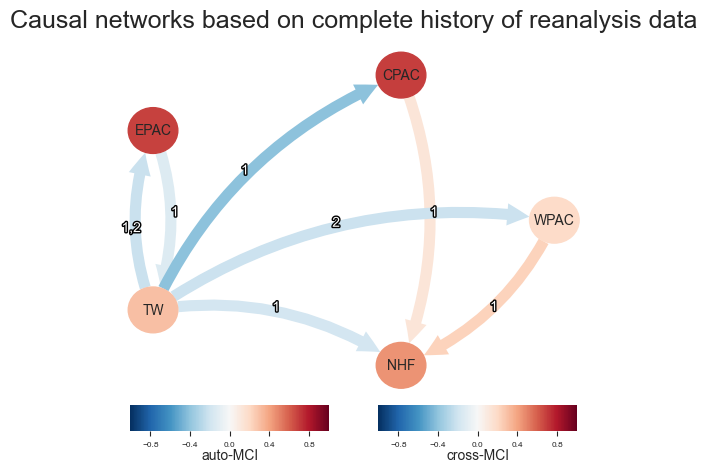

In [52]:
link_robustness_complete_reanalysis(extended_data, parcorr, extended = 2, info = True, model = 'reanalysis')

# Bootstrap Aggregating (Bagging)

Hier even de uitleg van de tigramite github!

The block-length of the bootstrap can optionally be used to better deal with autocorrelation, but its effect was not yet evaluated.

In [66]:
max_tau = 3              # the maximum time lag (deze is de eerste met goeie graph)
alpha_pc_bagging = None  # may be higher than the normal PCMCI alpha
bagging_samples = 400   # the number of bootstrap samples (recommended >100 on github)
bagging_blocklength = 3 # the block length of bootstrap samples
bagging_seed = 123      # with this we make sure we can reproduce the output

## Bagging Function

In [67]:
def bagging(data, var_names, tau_max, pc_alpha_bootstrap, boot_samples, boot_blocklength, seed=None, model = 'model'):
    """
    Run PCMCI algorithm and plot the results.

    :param data: The input data as a numpy array.
    :param var_names: List of variable names.
    :param tau_max: Maximum time lag.
    :param pc_alpha_bootstrap: Significance level for the bootstrap tests.
    :param boot_samples: Number of bootstrap samples.
    :param boot_blocklength: Block length of bootstrap samples.
    :param seed: Seed for the random number generator.
    """
    # Detrending and deseasonalizing
    df_processed = pd.DataFrame({name: deTrend_deSeasonalize(data[:, i], show_plot=False)
                                 for i, name in enumerate(var_names)})
    
    # Creating a Tigramite DataFrame
    tigramite_df = pp.DataFrame(df_processed.values,
                                datatime=np.arange(df_processed.shape[0]),
                                var_names=var_names)

    # Initialize PCMCI object
    pcmci = PCMCI(dataframe=tigramite_df, cond_ind_test=ParCorr(), verbosity=0)

    # Run the PCMCI with bootstrapping
    results = pcmci.run_bootstrap_of(
        method='run_pcmciplus',
        method_args={'tau_max': tau_max, 'pc_alpha': pc_alpha_bootstrap},
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=seed)

    # Get results
    boot_linkfreq = results['summary_results']['link_frequency']
    boot_graph = results['summary_results']['most_frequent_links']
    val_mat = results['summary_results']['val_matrix_mean']

    # Plot the graph
    tp.plot_graph(
        graph=boot_graph,
        val_matrix=val_mat,
        link_width=boot_linkfreq,
        var_names=var_names,
        
    )
    plt.title(f'Causal networks using Bagging based on {model} data', fontsize=16)
    plt.show()
    
#    # Plotting
#   tp.plot_graph(
#        val_matrix=val_mat,
#        graph=boot_graph,
#        var_names=tigramite_df.var_names,
#        link_matrix=boot_linkfreq > 0.1,  # This threshold can be adjusted.
#        link_colorbar_label='cross-MCI (edges)',
#        node_colorbar_label='auto-MCI (nodes)',
#        ax=ax
#    )
  #  ax.set_title(f'Causal networks using Bagging based on {model} data', fontsize=16)  # Set the title of the plot
 #   plt.show()

## Three Node Bagging

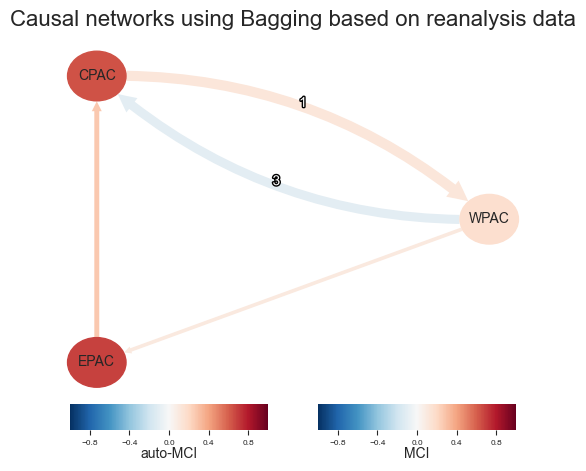

In [68]:
bagging(extended_data, ['WPAC', 'CPAC', 'EPAC'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')

## Four Node Bagging

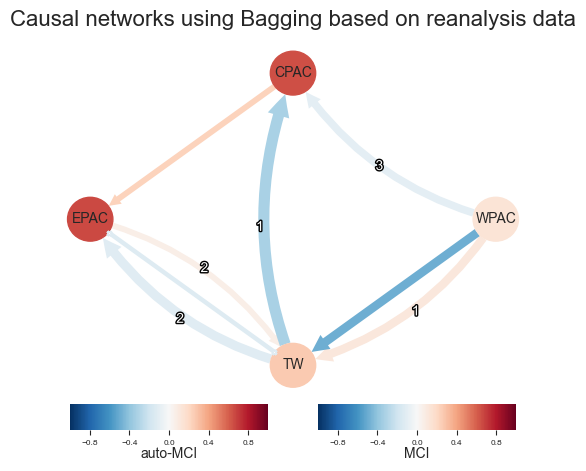

In [69]:
bagging(extended_data, ['WPAC', 'CPAC', 'EPAC', 'TW'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')

## Five Node Bagging

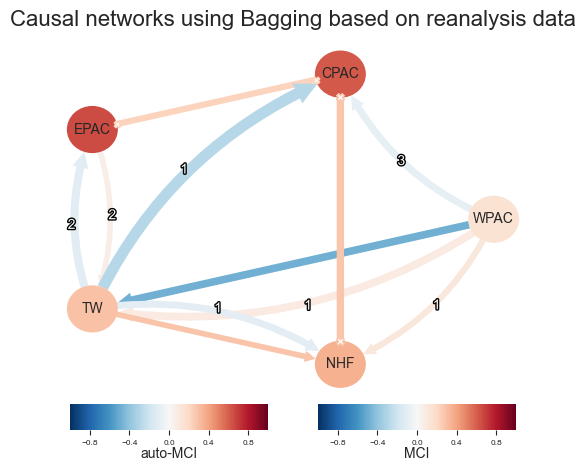

In [70]:
bagging(extended_data, ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')

## Split Bagging

To compare our bagging results to the results of the base model, we will define a function that will split the observation in two time period sets, and bags over those two sets. 

In [71]:
def bagging_split(data, var_names, tau_max, pc_alpha_bootstrap, boot_samples, boot_blocklength, seed=None, model = 'model'):
    """
    Run PCMCI algorithm and plot the results.

    :param data: The input data as a numpy array.
    :param var_names: List of variable names.
    :param tau_max: Maximum time lag.
    :param pc_alpha_bootstrap: Significance level for the bootstrap tests.
    :param boot_samples: Number of bootstrap samples.
    :param boot_blocklength: Block length of bootstrap samples.
    :param seed: Seed for the random number generator.
    """
    # Detrending and deseasonalizing
    df_processed = pd.DataFrame({name: deTrend_deSeasonalize(data[:, i], show_plot=False)
                                 for i, name in enumerate(var_names)})
    
    T = len(df_processed) # Get the length of the dataframe 
    split_index = T // 2  # And divide by two so we can use it to make split df's
    
    df_firsthalf = df_processed.iloc[:split_index]  # Contains rows from the start till split_index (exclusive)
    df_secondhalf = df_processed.iloc[split_index:]
    
    # Creating a Tigramite DataFrame
    tigramite_df_firsthalf = pp.DataFrame(df_firsthalf.values,
                                datatime=np.arange(df_firsthalf.shape[0]),
                                var_names=var_names)
    tigramite_df_secondhalf = pp.DataFrame(df_secondhalf.values,
                                datatime=np.arange(df_secondhalf.shape[0]),
                                var_names=var_names)
    
#    tigramite_df_firsthalf = pp.DataFrame(tigramite_df.values[:split_index, :],
#                              datatime=np.arange(split_index),
#                              var_names=tigramite_df.var_names)

#   tigramite_df_secondhalf = pp.DataFrame(tigramite_df.values[split_index:, :],
#                               datatime=np.arange(split_index, n_timepoints),
#                              var_names=tigramite_df.var_names)
    
    # Initialize PCMCI object
    pcmci_firsthalf = PCMCI(dataframe=tigramite_df_firsthalf, cond_ind_test=ParCorr(), verbosity=0)
    pcmci_secondhalf = PCMCI(dataframe=tigramite_df_secondhalf, cond_ind_test=ParCorr(), verbosity=0)

    # Run the PCMCI with bootstrapping
    results_firsthalf = pcmci_firsthalf.run_bootstrap_of(
        method='run_pcmciplus',
        method_args={'tau_max': tau_max, 'pc_alpha': pc_alpha_bootstrap},
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=seed)
    results_secondhalf = pcmci_secondhalf.run_bootstrap_of(
        method='run_pcmciplus',
        method_args={'tau_max': tau_max, 'pc_alpha': pc_alpha_bootstrap},
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=seed)
    
    # Get results
    boot_linkfreq_firsthalf = results_firsthalf['summary_results']['link_frequency']
    boot_graph_firsthalf = results_firsthalf['summary_results']['most_frequent_links']
    val_mat_firsthalf = results_firsthalf['summary_results']['val_matrix_mean']
    
    boot_linkfreq_secondhalf = results_secondhalf['summary_results']['link_frequency']
    boot_graph_secondhalf = results_secondhalf['summary_results']['most_frequent_links']
    val_mat_secondhalf = results_secondhalf['summary_results']['val_matrix_mean']
    
#    # Plot the graph
#    tp.plot_graph(
#        graph=boot_graph,
#        val_matrix=val_mat,
#        link_width=boot_linkfreq,
#        var_names=var_names,
#    )
#    plt.title(f'Causal networks using Bagging based on {model} data', fontsize=16)  # Set the title of the plot
#    plt.show()

    
   # plot the graph
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)
    tp.plot_graph(
        graph=boot_graph_firsthalf,
        val_matrix=val_mat_firsthalf,
        link_width=boot_linkfreq_firsthalf,
        var_names=var_names,
        fig_ax=(fig, axes[0]))  # Assigning to the first subplot
    axes[0].set_title('First half')
    tp.plot_graph(
        graph=boot_graph_secondhalf,
        val_matrix=val_mat_secondhalf,
        link_width=boot_linkfreq_secondhalf,
        var_names=var_names,
        fig_ax=(fig, axes[1]))  # Assigning to the second subplot
    axes[1].set_title('Second half')
    fig.suptitle(f'Causal networks using baggin based on {model} data', fontsize = 18)
    plt.subplots_adjust(hspace=0.8)
    plt.show()

### Three Node Split Bagging

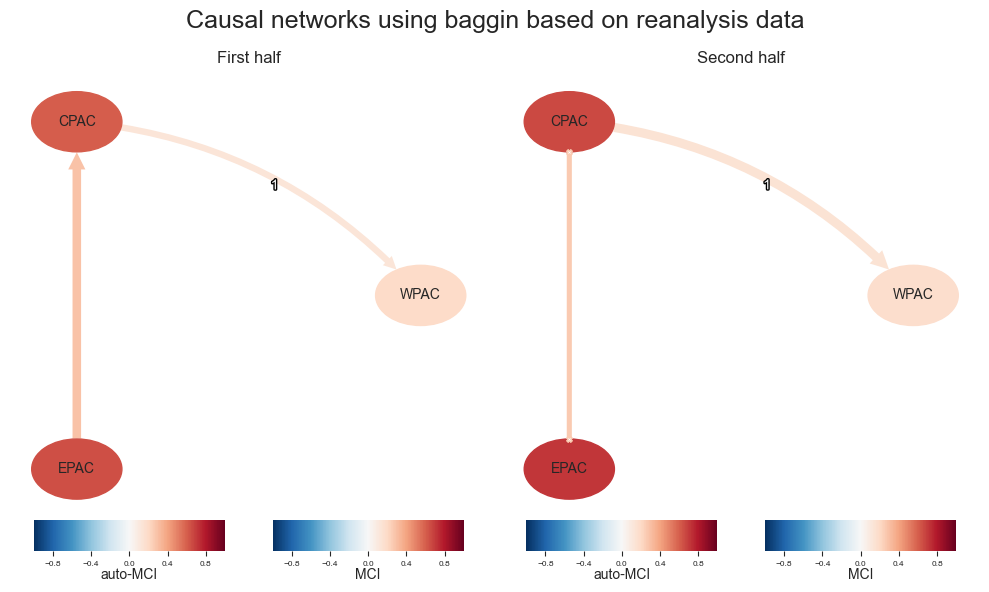

In [72]:
bagging_split(extended_data, ['WPAC', 'CPAC', 'EPAC'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')

### Four Node Split Bagging

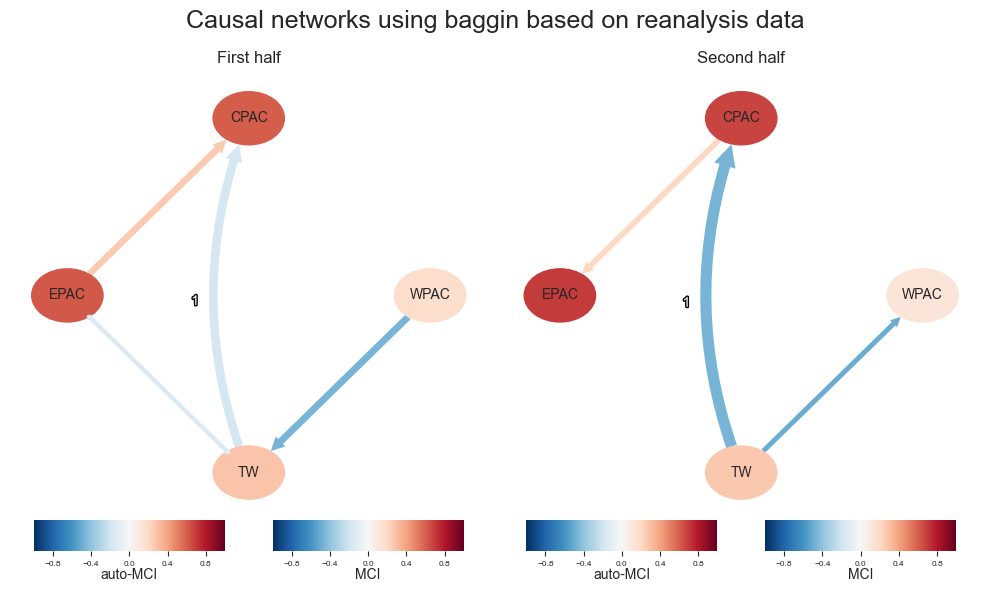

In [73]:
bagging_split(extended_data, ['WPAC', 'CPAC', 'EPAC','TW'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')

### Five Node Split Bagging

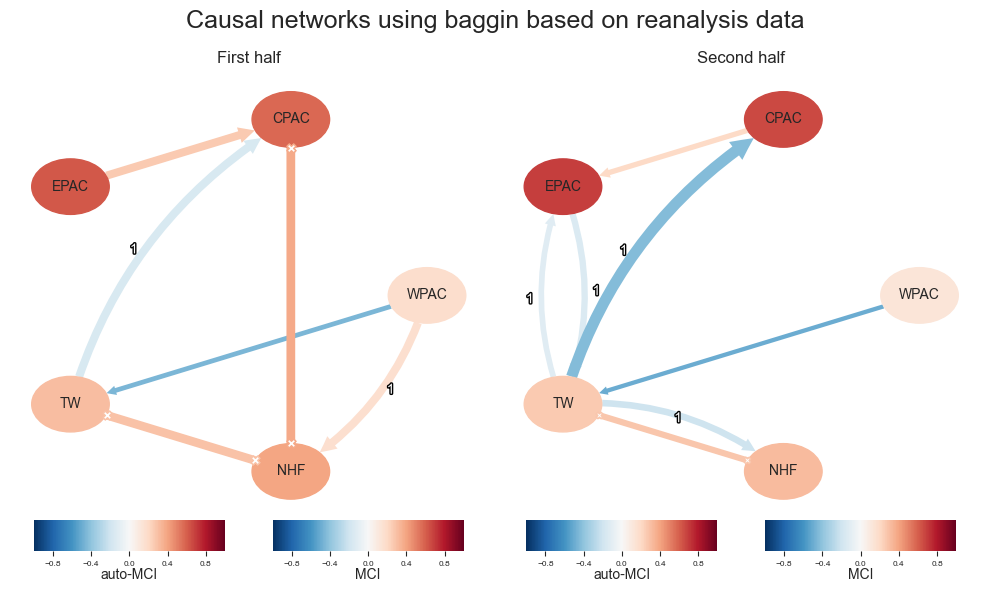

In [74]:
bagging_split(extended_data, ['WPAC', 'CPAC', 'EPAC','TW','NHF'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')

## The first code

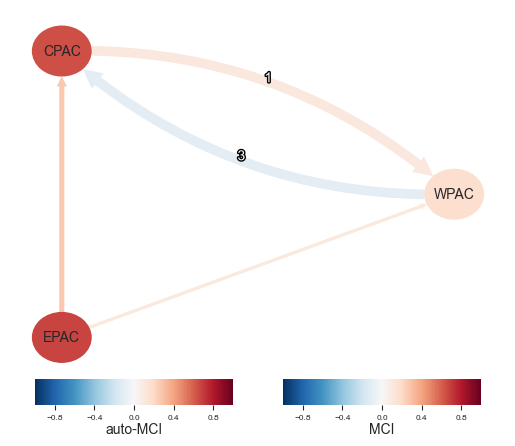

In [75]:
pc_alpha_bootstrap = None
boot_samples = 200

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 3

var_names = ['WPAC', 'CPAC', 'EPAC']
extended_data_3N = extended_data[:,:3]

# make data frame of data
df = pd.DataFrame(extended_data_3N, columns=var_names)
#dataframe = pp.DataFrame(extended_data_3N, 
 #                           datatime = np.arange(len(extended_data_3N)), 
  #                          var_names=var_names)

cpac_detrend = deTrend_deSeasonalize(df['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df['WPAC'], show_plot = False)
        
df_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                    'CPAC': cpac_detrend, 
                                    'EPAC': epac_detrend})

tigramite_df = pp.DataFrame(df_processed.values,
                            datatime=np.arange(df_processed.shape[0]),
                            var_names=var_names)

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=tigramite_df, cond_ind_test=ParCorr(), verbosity=0)
tau_max = 3

#results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=0.05)  # Ensure parameters are defined

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=tigramite_df.var_names,
    ); plt.show()

In [ ]:
# tau en bakje = 6
bagging(extended_data, ['WPAC', 'CPAC', 'EPAC'], max_tau, alpha_pc_bagging, bagging_samples, bagging_blocklength, bagging_seed, model = 'reanalysis')